# Introduction

## Overview

This is a variation of [the original Analysis notebook](https://github.com/kamfonas/squadBERT/blob/main/notebooks/Analysis_v1.ipynb) with added functionality to exploit json files produced after validation or testing. 

Our premise, as described in more detail in the Analysis notebook, is that in addition to using exact match or F1 scores, measuring the proximity to the top prediction of the correct answer, provides useful insight into the progress of learning, hyperparameter tuning, or the comparison of models and architectures. 

We initially adopt the formatting proposed by Huggingface since their hub includes a large collection of architectures and models for the QA task. At the end of validation or test runs, a post-processing function yields a json file with the N-best answers for each example. Using N=20, for example, we can  extract the top 20 predictions for each example tested. Since we know the top 4 answers for every example from the golden dataset, we can try to match them in the top 20-list, and rank or score the proximity of the correct answers to highest confidence predictdion. 

This notebook demonstrates how we can pair the golden answers to our top-N predictions and calculates various metrics that measure proximity or rank of the correct answer.

## Postprocessing and Metrics 
We follow the postprocessing of the question-answering model output from logits to the computation of exact match (EM) and F1 metrics. 
These metrics deal with the top prediction. When this prediction is incorrect, it is common that a golden answer matches some other one of the top-N predictions. We look for a statistic that quantifies the proximity of the golden aswer in the top-N prediction pecking order of the evaluation set. We use the discounted rank of the prediction that matches the golden answer, so that the further down the order of predictions the lower the contribution of a correct match.  

## From Logits to Predictions
We assume that our evaluation set contains $M$ question-answer examples with varying context length $N^{(i)}$ measured in word tokens. For each example $i \in [1,M]$ the output layer of the model returns a start and an end prediction vector of logit values $\hat{y}^{S(i)}_j$  and $\hat{y}^{E(i)}_j$ where $j \in [1,N^{(i)}]$. These two logit vectors are treated as estimations of the *log of the odds* that the token in position $j$ marks the start or end token position of the answer segment respectively. By passing these logit vectors through a softmax function, the log of the odds is converted to prediction probability distribution vectors, $\hat{p}_j^{S(i)}$ and $\hat{p}_j^{E(i)}$ of the same shape as the logits.  

 In a perfect world, we should be able to use the highest probability start and end indexes to identify the highest probability answer prediction. 
    $$S^{(i)}=\underset{j\in [1,N]}{\arg\max}\,(\hat{p}_j^{S(i)})$$
    $$E^{(i)}=\underset{j\in[1,N]}{\arg\max}\,(\hat{p}_j^{E(i)})$$
The best answer prediction is the span of the context that starts at position $S^{(i)}$ and ends at $E^{(i)}$.   
 In the real world these answer spans may be invalid. For example, the end-position may precede the start-position or the  span length may exceed the allowed threshold or either of the positions may be out of bounds. These situations can be checked and controlled by constraints or other strategies that are implementation dependent. Such a strategy is to avoid the out-of-bounds constraint by properly masking the token sequence before applying the softmax. 
 
 Since some spans may be invalid, we need a strategy to choose the next best prediction span if the top choice is invalid. Should we try the next best end or maybe the next start or skip to the next pair? Or should we consider the question unanswerable? Instead of dealing with two independent probability distributions for the starts and ends it would be better to have a function that generates an ordered list of answers and their corresponding probabilities. This list could theoretically include all possible spans, but in practice a handful of them would be enough. In our tests, we use the  Huggingface framework which uses such a method.

Visualize a weight matrix of all possible combinations of start (rows) and end (columns): $\bf{\hat{w}}^{(i)} \in \mathcal{R}^{N^{(i)} \times N^{(i)}}$. Each cell of the matrix represents a possible span, and the value denotes the rank from most probable to least probable answer prediction. Cells denoting invalid spans should have zero-weight. For example, all elements below the diagonal that denote ends before starts should be zero, or outside the band where the answer span length exceeds a given threshold would also be set to zero. The rest of the valid cells will be assigned a computed probability (or weight) that reflects our chosen prioritization scheme. We need a function that checks span validity and combines start and end probabilities to produce a single value for each candidate span. The following are some of these choices:

### Product:
   The favored combinations are those which have both start and end probabilities high. A near-zero end probability penalizes the combination:
   $$w^{SE}=p^S p^E$$

### Harmonic Mean:
   This is a variation of the product method:
   $$w^{SE}=\frac{2 p^S p^E}{p^S + p^E}$$

### Average:
   The average probability of start and end is what we used in our evaluation. 
   $$w^{SE}=\frac{p^S + p^E}{2}$$

### Weighted Average:
   The idea here is to place more emphasis on the probability of the starting token than the ending token. 
   $$w^{SE}=\frac{w^S p^S + w^E p^E}{w^S+w^E}$$

   Weighing the start twice as much as the end is proposed [here](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/reports/default/15812785.pdf)

The cells of the matrix can be ordered with the top choice being the prediction. We use the top-N choices out of this matrix to support a statistic that measures the proximity of the golden answer to the top prediction.  

In practice, it is more efficient to reduce the matrix to the top-ranking starts and ends and avoid the cost of building the whole matrix. It would be interesting to study how each of these methods affect the prediction and the impact on performance. We have not been able to identify such a study although researchers do consider and try such alternatives in optimizing their models. 


In [74]:
#https://stackoverflow.com/questions/63329657/python-3-7-error-unsupported-pickle-protocol-5
import pickle5 as pickle
import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Rectangle
import seaborn as sns
import urllib
import wget
from utils_anal import *
#rename things that arent logs later
import os
from pathlib import Path
import json
from collections import Counter
import datetime
import datasets
from datasets import ClassLabel, Sequence, load_dataset, load_metric
import random
import pandas as pd
from IPython.display import display, HTML
import datetime
import string
import re
from statistics import  median_grouped
from tqdm import tqdm


In [76]:
def download_url(url, output_path, show_progress=True):
    class DownloadProgressBar(tqdm):
        def update_to(self, b=1, bsize=1, tsize=None):
            if tsize is not None:
                self.total = tsize
            self.update(b * bsize - self.n)

    if show_progress:
        # Download with a progress bar
        with DownloadProgressBar(unit='B', unit_scale=True,
                                 miniters=1, desc=url.split('/')[-1]) as t:
            urllib.request.urlretrieve(url,
                                       filename=output_path,
                                       reporthook=t.update_to)
    else:
        # Simple download with no progress bar
        urllib.request.urlretrieve(url, output_path)

stanford_squad2_dev_url = "https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json"
save_stanford_squad2 = "stanford_squad2_dev.json"
download_url(stanford_squad2_dev_url,save_stanford_squad2)

dev-v2.0.json: 4.37MB [00:01, 2.21MB/s]                            



## Load the SQuAD Dataset

We now download the squad_v2 dataset from the hub. We will use it to get the golden answers so that we can calculate performance metrics. The dataset class has a method for loading the dataset from the huggingface hub or from a disk location. The loaded object belongs to that class



In [82]:
dataset_name = "squad_v2"
#dataset_name = "squad"

raw_datasets = load_dataset(dataset_name)
print('The raw dataset dictionary contains two datasets of type %s:' % (type(raw_datasets["validation"])))
raw_datasets

#['num_rows']


Reusing dataset squad_v2 (/home/farsipal/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d)


The raw dataset dictionary contains two datasets of type <class 'datasets.arrow_dataset.Dataset'>:


DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})

The following function allows us to inspect the contents of the downloaded data. Every time the function is invoked it prduces a new set of random selections.

Every time you execute this function it will generate new samples. Use it to find IDs you want to use for testing.

In [83]:
show_random_elements(raw_datasets["validation"])

,id,title,context,question,answers
0,5ad03c2977cf76001a686eb7,Scottish_Parliament,"The specific devolved matters are all subjects which are not explicitly stated in Schedule 5 to the Scotland Act as reserved matters. All matters that are not specifically reserved are automatically devolved to the Scottish Parliament. Most importantly, this includes agriculture, fisheries and forestry, economic development, education, environment, food standards, health, home affairs, Scots law – courts, police and fire services, local government, sport and the arts, transport, training, tourism, research and statistics and social work. The Scottish Parliament has the ability to alter income tax in Scotland by up to 3 pence in the pound. The 2012 Act conferred further fiscal devolution including borrowing powers and some other unconnected matters such as setting speed limits and control of air guns.",The 2002 Act granted further fiscal devolution including what?,"{'text': [], 'answer_start': []}"
1,5a38b819a4b263001a8c18c9,1973_oil_crisis,"The embargo had a negative influence on the US economy by causing immediate demands to address the threats to U.S. energy security. On an international level, the price increases changed competitive positions in many industries, such as automobiles. Macroeconomic problems consisted of both inflationary and deflationary impacts. The embargo left oil companies searching for new ways to increase oil supplies, even in rugged terrain such as the Arctic. Finding oil and developing new fields usually required five to ten years before significant production.",What did macroeconomic problems cause oil companies to search for?,"{'text': [], 'answer_start': []}"
2,572980f9af94a219006aa4d3,Prime_number,"are prime. Prime numbers of this form are known as factorial primes. Other primes where either p + 1 or p − 1 is of a particular shape include the Sophie Germain primes (primes of the form 2p + 1 with p prime), primorial primes, Fermat primes and Mersenne primes, that is, prime numbers that are of the form 2p − 1, where p is an arbitrary prime. The Lucas–Lehmer test is particularly fast for numbers of this form. This is why the largest known prime has almost always been a Mersenne prime since the dawn of electronic computers.",What test is especially useful for numbers of the form 2p - 1?,"{'text': ['The Lucas–Lehmer test', 'Lucas–Lehmer', 'Lucas–Lehmer', 'Lucas–Lehmer', 'Lucas–Lehmer test'], 'answer_start': [347, 351, 351, 351, 351]}"


We are interested in the validation dataset. Here is its type:

In [4]:
type(raw_datasets["validation"])

datasets.arrow_dataset.Dataset

## Index by ID


In order to be able to match the entries of the original dataset with those of our prediction, we need to map each ID to the respective row number of the validation raw dataset. We construct an index, as a dictionary, keyed on the ID from the validataion raw dataset and pointing to the corresponding row-number of the validation dataset.

In [5]:
ix_id = dict([(x['id'],i) for i,x in enumerate(raw_datasets['validation'])])

Now, we can use this index to get to the golden answer for a given id. This mapping is repeated inside the class defined in the next section below. 



# The ResultSet Class

## Class Overview


To facilitate management and data collection we build a dictionary of available data sources derived from runs logged under a user-provided root directory (saveRoot.)

The SaveRoot descendent directories are searched for all instances of a fiile named *eval_nbest_predictions.json*. Every directory containing this file is a potential source for N-best predictions. We load the ones that satisfy these additional conditions:

1.  if a *config.json* file exists in the same directory
2.  If a file named *all_results.json* exists in the same directory

These files are written by the training/evaluation process after successful completion of a run. 

The function **get_resultsets_from_root(saveRoot)** performs the above steps and returns a directory with the following information:

<dl>
<dt><b>mtime</b></dt>
    <dd>The last modification time of the eval_nbest_predictions.json file</dd>
<dt><b>config</b></dt>
    <dd>Model configuration of used to produce the top-N results</dd>
<dt><b>all_results</b></dt>
    <dd>The results of the last run that produced the top-N results</dd>
<dt><b>topN</b></dt>
    <dd>A dictionary keyed on the ID of each question pointing to an ordered N-long list in descending order of probability with the predicted details. These details are organized as dictionaries containing:
    </ul>
    <li><b>start logit</b></li>
    <li><b>end logit</b></li>
    <li><b>answer text</b></li>
    <li><b>probability</b></li>
    </ul>
    </dd>
<dt><b>null odds</b></dt>
    <dd>The odds determining the likelihood that this is a no-answer question for each example</dd>
</dl>

We augment our **prediction** dictionary to include the **id** as a field, the **rank** of each predicted answer (with values from 0 to N), and the gold answers (**goldenAnswers**), which is a list containing the distinct text of the answers found in the SQuAD_V2 dataset. Finally, we also include an indicator showing whether the prediction is the **correct** answer.

The **contextLen** field denotes the original number of characters in the context field. This can be used for normalization when comparing probabilities of different size contexts. A more appropriate length would be the number of tokens or number of words in the context.  

Notice that to indicate no answer, the prediction text is an empty string while the goden answer is an empty list. 

The class, when initialized with a root directory, searches all its subdirectories to find top-N prediction output files. It also accepts an original examples dataset which was used as input to our training/evaluation script. From these two pieces of information, the class materializes a number of dictionaries and carries methods for data extraction and generating all necessary values for visualizations. 

Method topNPredsDF takes an optional maxBins parameter that sets a limit to the rank values. The function returns a pandas dataframe that contains the following columns:
    <ul>
    <li><b>start logit</b></li>
    <li><b>end logit</b></li>
    <li><b>answer text</b></li>
    <li><b>probability</b> derived from the combination of start and end probabilities</li>
    <li><b>experiment</b> derived from the output directory path</li>
    <li><b>example id</b></li>
    <li><b>rank</b> in descending order of probability for as many available ranks are available in the logs.
    <li><b>bins</b> this is driven by the topK parameter and is assigned the rank value up to the maxBins parameter. This is a convenient way to throttle very long top-N lists to a desired max size for plotting purposes. All the rows that exceed the rank are still available, but the rank number is the same maximum value (defaults to 20)</li>
    <li><b>correct</b> is True if it matches one of the golden answers using the exact match logic (EM) regardless of rank</li>
    <li><b>contextLen</b> in characters</li>
    </ul>



## Create a Class Instance and List Summary Info 

In [6]:
RS = ResultSet("../save/squad_v2",raw_datasets["validation"])


In [7]:
RS.summaryDF()


,experiment,mtime,example_count,topK
0,/bert-base-uncased/001,2021-08-18T10:46:51.164099,11873,10
1,/bert-base-uncased/007,2021-08-19T03:49:13.564274,11873,10
2,/bert-base-uncased/009,2021-08-26T10:57:47.314041,11873,100
3,/bert-base-uncased/010,2021-09-11T11:28:41.705976,11873,10
4,/bert-large-cased-whole-word-masking/003,2021-08-24T21:11:13.918531,11873,10
5,/deepset/bert-large-uncased-whole-word-masking...,2021-09-03T18:03:23.005489,11873,10
6,/mrm8488/longformer-base-4096-finetuned-squadv...,2021-08-22T16:27:11.291280,11873,10
7,/mrm8488/longformer-base-4096-finetuned-squadv...,2021-09-03T17:45:31.351507,11873,10
8,/navteca/electra-base-squad2/005,2021-08-17T12:50:17.532495,11873,10
9,/navteca/electra-base-squad2/006,2021-08-20T15:27:11.066897,11873,10


In [8]:

with open('../assets/experSummary.tex','w') as F:
    F.write(RS.summaryDF().to_latex())

In [9]:
RS.experiments

['/bert-base-uncased/001',
 '/bert-base-uncased/007',
 '/bert-base-uncased/009',
 '/bert-base-uncased/010',
 '/bert-large-cased-whole-word-masking/003',
 '/deepset/bert-large-uncased-whole-word-masking-squad2/001',
 '/mrm8488/longformer-base-4096-finetuned-squadv2/009',
 '/mrm8488/longformer-base-4096-finetuned-squadv2/011',
 '/navteca/electra-base-squad2/005',
 '/navteca/electra-base-squad2/006',
 '/navteca/electra-base-squad2/007',
 '/navteca/roberta-base-squad2/001',
 '/navteca/roberta-base-squad2/002',
 '/twmkn9/distilbert-base-uncased-squad2/003',
 '/twmkn9/distilbert-base-uncased-squad2/004',
 '/twmkn9/distilbert-base-uncased-squad2/008']

The summary lists the name (derived from the directory structure) for each experiment captured in the class, followed by the last modification date, , the number of examples in the dataset, and the length of the top-K predictions recorded in the logs.


## Assign Labels to Experiments
We assign abbreviated labels for each experiment to keep legends small

In [10]:
short_labels = []
for exp in RS.experiments:
    nm1 = exp.split('/')
    nm0 = nm1[-2]
    #print(exp,str(namSplit2[0])+'/'+str(namSplit1[-1]))
    nm0 = re.sub('-base','',nm0)
    nm0 = re.sub('large','lg',nm0)
    nm0 = re.sub('uncased','uc',nm0)
    nm0 = re.sub('cased','cas',nm0)
    nm0 = re.sub('whole-word-masking','wwm',nm0)
    nm0 = re.sub('-finetuned','',nm0)
    nm0 = re.sub('-squad.*2','-sq2',nm0)
    nm0 = re.sub('-[0-9]{4}','',nm0)  
    short_labels.append(str(nm0+'/'+str(nm1[-1])))
RS.set_labels(short_labels)
RS.labels

['bert-uc/001',
 'bert-uc/007',
 'bert-uc/009',
 'bert-uc/010',
 'bert-lg-cas-wwm/003',
 'bert-lg-uc-wwm-sq2/001',
 'longformer-sq2/009',
 'longformer-sq2/011',
 'electra-sq2/005',
 'electra-sq2/006',
 'electra-sq2/007',
 'roberta-sq2/001',
 'roberta-sq2/002',
 'distilbert-uc-sq2/003',
 'distilbert-uc-sq2/004',
 'distilbert-uc-sq2/008']

In [11]:
abbrevLabel = {RS.experiments[i] : RS.labels[i] for i in range(len(RS.labels))}

## Looking-up Information for a Specific Example ID

In [12]:
RS.dataset[RS.ix_id['571c96095efbb31900334dc0']] 

{'id': '571c96095efbb31900334dc0',
 'title': 'Oxygen',
 'context': 'Oxygen is more soluble in water than nitrogen is. Water in equilibrium with air contains approximately 1 molecule of dissolved O\n2 for every 2 molecules of N\n2, compared to an atmospheric ratio of approximately 1:4. The solubility of oxygen in water is temperature-dependent, and about twice as much (14.6 mg·L−1) dissolves at 0 °C than at 20 °C (7.6 mg·L−1). At 25 °C and 1 standard atmosphere (101.3 kPa) of air, freshwater contains about 6.04 milliliters (mL) of oxygen per liter, whereas seawater contains about 4.95 mL per liter. At 5 °C the solubility increases to 9.0 mL (50% more than at 25 °C) per liter for water and 7.2 mL (45% more) per liter for sea water.',
 'question': 'How much more oxygen dissolves at 0 degrees C than at 20 degrees C?',
 'answers': {'text': ['twice',
   '50% more',
   'about twice as much',
   'twice as much',
   'twice'],
  'answer_start': [286, 579, 280, 286, 286]}}

In [13]:
RS.topNPreds()[0]['5728fc9e1d04691400778f15'][0:1]

[{'start_logit': 6.09079647064209,
  'end_logit': 5.010820388793945,
  'text': '',
  'probability': 0.999997615814209,
  'experiment': '/bert-base-uncased/001',
  'id': '5728fc9e1d04691400778f15',
  'rank': 0,
  'goldAns': ["the leaflets will have to be given to the leafleter's own jury as evidence",
   "if they arrest fully informed jury leafleters, the leaflets will have to be given to the leafleter's own jury as evidence"],
  'correct': False,
  'contextLen': 1453,
  'bin': 0}]

In [14]:
ids=['57263c78ec44d21400f3dc7c', '57267d52708984140094c7da', '5728dc2d3acd2414000e0080', '572742bd5951b619008f8787']
RS.dataset[RS.ix_id[ids[0]]] 

{'id': '57263c78ec44d21400f3dc7c',
 'title': 'Packet_switching',
 'context': 'ARPANET and SITA HLN became operational in 1969. Before the introduction of X.25 in 1973, about twenty different network technologies had been developed. Two fundamental differences involved the division of functions and tasks between the hosts at the edge of the network and the network core. In the datagram system, the hosts have the responsibility to ensure orderly delivery of packets. The User Datagram Protocol (UDP) is an example of a datagram protocol. In the virtual call system, the network guarantees sequenced delivery of data to the host. This results in a simpler host interface with less functionality than in the datagram model. The X.25 protocol suite uses this network type.',
 'question': '2 differences betwen X.25 and ARPNET CITA technologies ',
 'answers': {'text': ['Two fundamental differences involved the division of functions and tasks between the hosts at the edge of the network and the netwo

## Explore random example top-K predictions
But first, let's explore the data dictionary we assembled and look at a three random examples. 

1.  We first select **num_examples** (default to 3) numbers in the range of all the keys of the data dictionary
2.  Look up the keys that appear at these three sequencial positions in the sequence of all keys
3.  Get the values pointed to by those keys
4.  Build a data frame by traversing the list of each of the chosen values and extracting the field names and fields.
5.  Finally display the rank, predicted answer text,  golden answer list,  probability used to rank this choice, and whether this is a correct prediction. 

Every time the command is issued new random samples are displayed. 

In [15]:
DF = RS.show_random_qa_predictions(3,num_examples = 2, verbose = False)
DF


,id,rank,text,goldAns,probability,correct
0,571cebc05efbb31900334e4c,0,"peroxides, chlorates, nitrates, perchlorates, ...","[compounds of oxygen, peroxides, chlorates, ni...",0.986093,True
1,571cebc05efbb31900334e4c,1,"peroxides, chlorates, nitrates, perchlorates, ...","[compounds of oxygen, peroxides, chlorates, ni...",0.005686,False
2,571cebc05efbb31900334e4c,2,"peroxides, chlorates, nitrates, perchlorates, ...","[compounds of oxygen, peroxides, chlorates, ni...",0.002617,False
3,571cebc05efbb31900334e4c,3,"peroxides, chlorates, nitrates, perchlorates, ...","[compounds of oxygen, peroxides, chlorates, ni...",0.001858,False
4,571cebc05efbb31900334e4c,4,peroxides,"[compounds of oxygen, peroxides, chlorates, ni...",0.001261,False
5,571cebc05efbb31900334e4c,5,"such as peroxides, chlorates, nitrates, perchl...","[compounds of oxygen, peroxides, chlorates, ni...",0.001213,False
6,571cebc05efbb31900334e4c,6,"nitrates, perchlorates, and dichromates","[compounds of oxygen, peroxides, chlorates, ni...",0.000948,False
7,571cebc05efbb31900334e4c,7,,"[compounds of oxygen, peroxides, chlorates, ni...",0.000120,False
8,571cebc05efbb31900334e4c,8,"peroxides, chlorates, nitrates, perchlorates","[compounds of oxygen, peroxides, chlorates, ni...",0.000104,False
9,571cebc05efbb31900334e4c,9,compounds of oxygen with a high oxidative pote...,"[compounds of oxygen, peroxides, chlorates, ni...",0.000099,False


We can save a latex version of the output

In [16]:
with open('../assets/randomtopKpredictions2.tex','w') as F:
    F.write(DF.to_latex())

# EM and F1 Evaluation Metircs

These are extracted from the reported validation metrics for each experiment. They include exact match (EM) and F1 scores for the questions with answers and those with no answers separately, as well as all of them in total. Notice that there is no distinction between exact match and F1 for no-answer questions. 

In [17]:
RS.eval_metrics()

,EM_ans,F1_ans,F1-EM_ans_delta,noans,EM,F1,F1-EM_delta
0,70.951417,78.934411,7.982994,71.572750,71.262528,75.248310,3.985782
1,69.129555,76.915674,7.786119,77.022708,73.081782,76.969268,3.887485
2,68.522267,75.441761,6.919494,77.527334,73.031247,76.486041,3.454793
3,67.594467,74.788812,7.194345,77.443230,72.525899,76.117921,3.592022
4,76.180837,82.230080,6.049243,85.264929,80.729386,83.749677,3.020291
5,79.487179,85.444250,5.957071,82.321278,80.906258,83.880528,2.974271
6,75.033738,82.738118,7.704380,82.910008,78.977512,82.824186,3.846674
7,78.677463,85.534793,6.857330,81.126997,79.903984,83.327740,3.423756
8,77.918354,85.303190,7.384836,77.022708,77.469890,81.157021,3.687131
9,77.378543,85.117483,7.738940,81.328848,79.356523,83.220453,3.863930


## F1 is highly correlated with Exact Match
The following plot uses the data above to demonstrate the high correlation between EM and F1 scores.

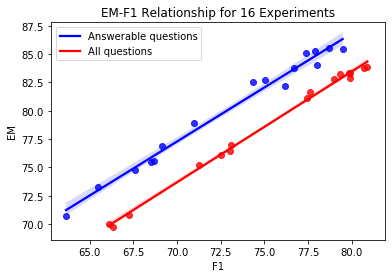

In [18]:
import seaborn as sns

X = RS.eval_metrics()

#create scatterplot with regression line
sns.regplot(x='EM_ans',y='F1_ans',color='blue',data=X)
sns.regplot(x='EM',y='F1',color='red',data=X)

#plt.scatter(X.EM_ans,X.F1_ans,color='blue')
#plt.scatter(X.noans,X.noans,color='green')
#plt.scatter(X.EM,X.F1,color='red')

plt.title("EM-F1 Relationship for %i Experiments" % len(X))
plt.legend(labels=["Answerable questions","All questions"])
plt.xlabel('F1')
plt.ylabel('EM')
plt.savefig('../assets/EM_F1_correlation.png',dpi=300)

# Golden Prediction Rank

## Definition

The Golden Prediction Rank, or simply Golden Rank (GR)  is defined as the rank of the highest probability prediction that exactly matches one of the answers. Operationally, this is better visualized following these steps:

1.  Assume an ordered list from highest to lowest probability of all valid spans of the context of a given example
2.  Starting from the top, in descending probability order, try each of the spans and identify the first one that contains an exact match to any of the golden answers
3.  The rank of that element is the golden prediction rank (GR) for that example


## Top-10 GRs Fine-Tuned Model Eval Runs

These include all evaluations using models that we did not fine-tune or train, but downloaded them already fine-tuned on SQuAD v2.

We first extract the top-K ranking predictions for each experiment. 

In [19]:
grls_np, nas_np, maxBins, medians, grls = RS.calc_golden_ranks(maxBins = 10,experimentIdx=None)

We can now plot the topN golden predictions by rank. We superimpose the medians of ranks > 0.

In [20]:
L = [i for i in range(len(RS.labels)) if 'eval' in RS.labels[i]]
L_eval = [5,7,10,12,15]
L = L_eval

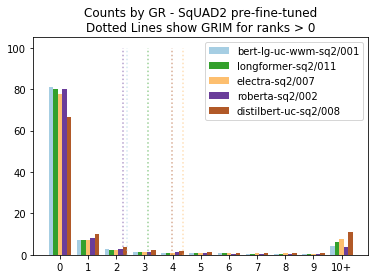

GRIMs: [2.38 3.13 4.38 2.23 3.99]
EMs [80.91 79.92 77.61 79.92 66.31]


In [21]:
#from utils_anal import plot_golden_EM_by_rank
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = False,
                skipRank0=False,labels=[RS.labels[i] for i in L],
                savePath='../assets/EM_rankEval.png' ,
                subject = 'SqUAD2 pre-fine-tuned')
print("GRIMs:",np.round(Ms,2))
print("EMs",np.round([x[0] for x in Hs],2))

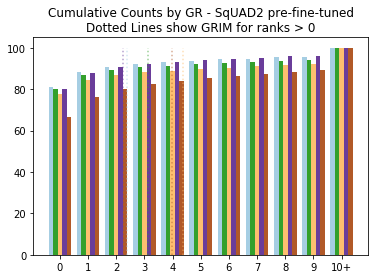

In [22]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = True,
                skipRank0=False,labels=None,#[RS.labels[i] for i in L],
                savePath='../assets/cumEM_rankEval.png'  ,
                subject = 'SqUAD2 pre-fine-tuned')


## Top-10 GRs Same Models with Our Added Fine-Tuning

These are the same models that have been fine-tuned by their authors, but we extended the fine-tuning with an additional up to 8 epochs

In [23]:
L = [i for i in range(len(RS.labels)) if i not in L_eval and i > 3]

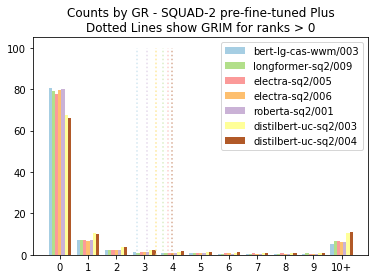

GRIMs: [2.73 3.65 3.84 3.4  3.11 3.41 3.97]
EMs [80.73 78.99 77.48 79.36 79.84 67.27 66.1 ]


In [24]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = False,
                skipRank0=False,labels=[RS.labels[i] for i in L],
                savePath='../assets/EM_rank10_ft_trVal.png'  ,
                subject = 'SQUAD-2 pre-fine-tuned Plus')
print("GRIMs:",np.round(Ms,2))
print("EMs",np.round([x[0] for x in Hs],2))

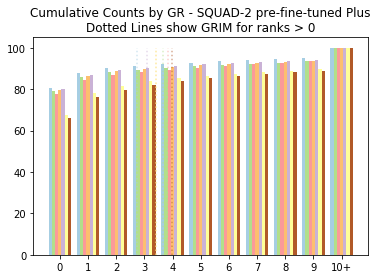

In [25]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = True,
                skipRank0=False,labels=None,#[RS.labels[i] for i in L],
                savePath='../assets/cumEM_rank10_ft_trVal.png'   ,
                subject = 'SQUAD-2 pre-fine-tuned Plus')


## Top-10 GRs BERT

These are BERT models that were pre-trained but not fine-tuned. We fine-tune them with 8 epochs of training. The only exception is the large BERT with the suffix "eval" which is fine-tuned and used without any training. Notice that this is not the same as the cased large we used and which we trained. 

In [26]:
#L = [i for i in range(len(RS.labels)) if 'bert-large' in RS.labels[i] or (i>11 and '/na/' not in RS.labels[i]) ]
#L = [i for i in range(len(RS.labels)) if  (i>11 and '/na/' not in RS.labels[i]) and 'large' not in RS.labels[i] ]
L = [0,1,2,3]

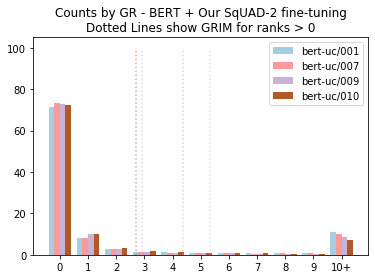

GRIMs: [5.34 4.38 2.91 2.7 ]
EMs [71.26 73.09 73.03 72.53]


In [27]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = False,
                skipRank0=False,labels=[RS.labels[i] for i in L],
                savePath='../assets/EM_rank10_bert.png'  ,
                subject = 'BERT + Our SqUAD-2 fine-tuning' )
print("GRIMs:",np.round(Ms,2))
print("EMs",np.round([x[0] for x in Hs],2))

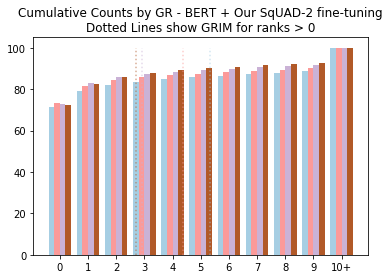

In [28]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = True,
                skipRank0=False,labels=None,#[RS.labels[i] for i in L],
                savePath='../assets/cumEM_rank10_bert.png' ,
                subject = 'BERT + Our SqUAD-2 fine-tuning' )


## Top-10 GRs Electra & Roberta

In [29]:
L = [i for i in range(len(RS.labels)) if 'electra' in RS.labels[i] or 'roberta' in RS.labels[i]]

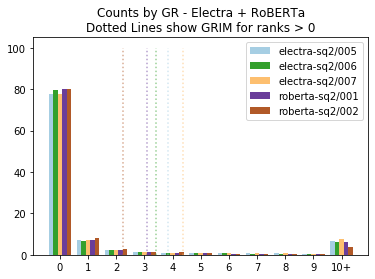

GRIMs: [3.84 3.4  4.38 3.11 2.23]
EMs [77.48 79.36 77.61 79.84 79.92]


In [30]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = False,
                skipRank0=False,labels=[RS.labels[i] for i in L],
                savePath='../assets/EM_rank10_electra.png' ,
                subject = 'Electra + RoBERTa' )
print("GRIMs:",np.round(Ms,2))
print("EMs",np.round([x[0] for x in Hs],2))

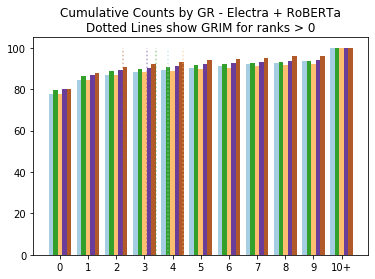

In [31]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = True,
                skipRank0=False,labels=None,#[RS.labels[i] for i in L],
                savePath='../assets/cumEM_rank10_electra.png' ,
                subject = 'Electra + RoBERTa'  )


## Top-10 GRs Fine-Tuned DistilBERT & Longformer

In [32]:
L = [i for i in range(len(RS.labels)) if 'distil' in RS.labels[i] or 'former' in RS.labels[i]]

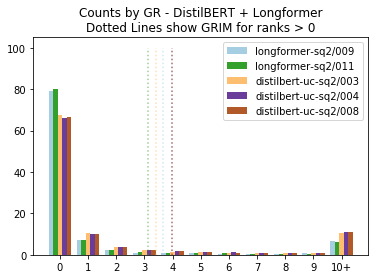

GRIMs: [3.65 3.13 3.41 3.97 3.99]
EMs [78.99 79.92 67.27 66.1  66.31]


In [33]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = False,
                skipRank0=False,labels=[RS.labels[i] for i in L],
                savePath='../assets/EM_rank10_long_dist.png' ,
                subject = 'DistilBERT + Longformer'  )
print("GRIMs:",np.round(Ms,2))
print("EMs",np.round([x[0] for x in Hs],2))

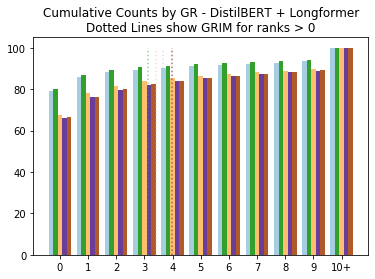

In [34]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = True,
                skipRank0=False,labels=None,#[RS.labels[i] for i in L],
                savePath='../assets/cumEM_rank10_long_dist.png'  ,
                subject = 'DistilBERT + Longformer')


## Top-10 GRs BERT Large (Cased vs. Uncased)

In [35]:
L = [i for i in range(len(RS.labels)) if 'bert-l' in RS.labels[i]]

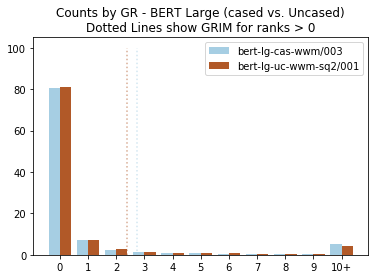

GRIMs: [2.73 2.38]
EMs [80.73 80.91]


In [36]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = False,
                skipRank0=False,labels=[RS.labels[i] for i in L],
                savePath='../assets/EM_rank10_bertLarge.png'  ,
                subject = 'BERT Large (cased vs. Uncased)')
print("GRIMs:",np.round(Ms,2))
print("EMs",np.round([x[0] for x in Hs],2))

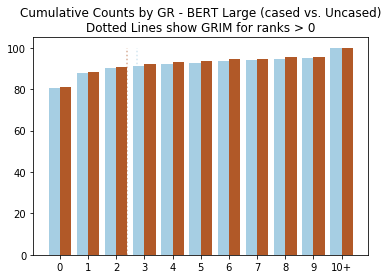

In [37]:
Hs,Ms = plot_golden_EM_by_rank(grls_np[L,:], 
                medians=medians[L], 
                cumulative = True,
                skipRank0=False,labels=None,#[RS.labels[i] for i in L],
                savePath='../assets/cumEM_rank10_bertLarge.png' ,
                subject = 'BERT Large (cased vs. Uncased)' )


## Top-100 Golden Prediction Ranks > 0 (One Experiment)

In [38]:
grls_np_100, _ , _ ,_, _ = RS.calc_golden_ranks(
    maxBins = 100,experimentIdx=2)

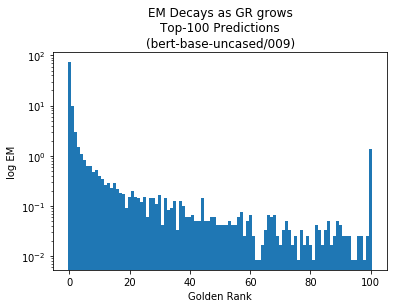

In [39]:
#Hs,Ms = plot_golden_EM_by_rank(grls_np_100, medians=[], cumulative = False,
#        skipRank0=False,labels=RS.labels,savePath='../assets/EM_rank100.png' )
lowx =0 #if skipRank0 else 0
title = 'EM Decays as GR grows\nTop-100 Predictions\n(bert-base-uncased/009)' 
#title = '%s%s' % (title,'\n(Ranks > 0 only)' if skipRank0 else '')
m = grls_np_100.shape[1]
maxBins = np.max(grls_np_100)
bins = [x for x in range(maxBins+2)]
A = plt.hist(grls_np_100.T,bins=maxBins+1,
        weights=np.ones(grls_np_100.T.shape)*100/m, 
        cumulative=False,align='left',histtype='bar',
        range=(lowx,(maxBins+1)))
plt.title(title)
plt.yscale("log")
plt.ylabel("log EM")
plt.xlabel("Golden Rank")
plt.savefig('../assets/EM_rank100.png',dpi=300,alpha=0.6)
plt.show()


# The Metrics


In [40]:
colors = cm.Paired(np.linspace(0, 1, 6))
cmap=sns.color_palette("tab10")
print(cmap)
colors = [cmap[i] for i in [0,0,0,1,2,2,2,3,3,4,4,5,5,5,1]]

metrics = RS.eval_metrics()
metrics['GRIM'] = medians
metrics['label'] = RS.labels
metrics['Model'] = [lbl.split('-')[0] for lbl in RS.labels]
metrics['Model'] = ['bert-lg' if 'bert-lg' in lbl else mod for mod,lbl in zip(metrics['Model'],RS.labels)]


metrics

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (1.0, 0.4980392156862745, 0.054901960784313725), (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), (0.5803921568627451, 0.403921568627451, 0.7411764705882353), (0.5490196078431373, 0.33725490196078434, 0.29411764705882354), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902), (0.4980392156862745, 0.4980392156862745, 0.4980392156862745), (0.7372549019607844, 0.7411764705882353, 0.13333333333333333), (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]


,EM_ans,F1_ans,F1-EM_ans_delta,noans,EM,F1,F1-EM_delta,GRIM,label,Model
0,70.951417,78.934411,7.982994,71.572750,71.262528,75.248310,3.985782,5.339695,bert-uc/001,bert
1,69.129555,76.915674,7.786119,77.022708,73.081782,76.969268,3.887485,4.383621,bert-uc/007,bert
2,68.522267,75.441761,6.919494,77.527334,73.031247,76.486041,3.454793,2.909091,bert-uc/009,bert
3,67.594467,74.788812,7.194345,77.443230,72.525899,76.117921,3.592022,2.700935,bert-uc/010,bert
4,76.180837,82.230080,6.049243,85.264929,80.729386,83.749677,3.020291,2.726027,bert-lg-cas-wwm/003,bert-lg
5,79.487179,85.444250,5.957071,82.321278,80.906258,83.880528,2.974271,2.379365,bert-lg-uc-wwm-sq2/001,bert-lg
6,75.033738,82.738118,7.704380,82.910008,78.977512,82.824186,3.846674,3.650000,longformer-sq2/009,longformer
7,78.677463,85.534793,6.857330,81.126997,79.903984,83.327740,3.423756,3.125767,longformer-sq2/011,longformer
8,77.918354,85.303190,7.384836,77.022708,77.469890,81.157021,3.687131,3.843750,electra-sq2/005,electra
9,77.378543,85.117483,7.738940,81.328848,79.356523,83.220453,3.863930,3.398601,electra-sq2/006,electra


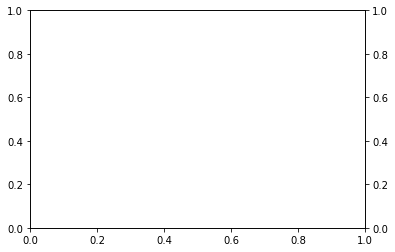

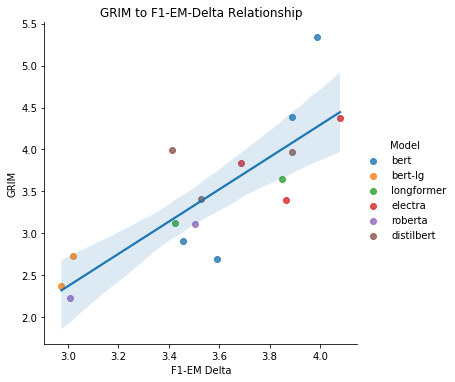

In [41]:
fig, ax = plt.subplots()
sns.lmplot(x='F1-EM_delta',y='GRIM',data=metrics, hue='Model', scatter=True ,fit_reg=False)
ax2 = ax.twinx()
sns.regplot(x='F1-EM_delta',y='GRIM',data=metrics,scatter=False)#, hue='Model')
#ax.set(xlabel="x-axis", ylabel="y-axis")plt.ylim(6.0, 0)
plt.title("GRIM to F1-EM-Delta Relationship")
#plt.legend(labels=["Answerable questions","All questions"])
plt.xlabel('F1-EM Delta')
plt.ylabel('GRIM')
plt.savefig('../assets/F1-EM_vs_GRIM_correlation.png',dpi=300,bbox_inches='tight')
plt.show()

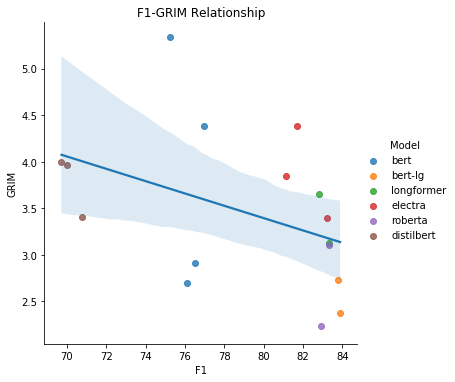

In [42]:
sns.lmplot(x='F1',y='GRIM',data=metrics, hue='Model', scatter=True ,fit_reg=False)
ax2 = ax.twinx()
sns.regplot(x='F1',y='GRIM',data=metrics,scatter=False)#, hue='Model')

plt.title("F1-GRIM Relationship")
plt.xlabel('F1')
plt.ylabel('GRIM')
plt.savefig('../assets/F1_vs_GRIM_correlation.png',dpi=300,bbox_inches='tight')

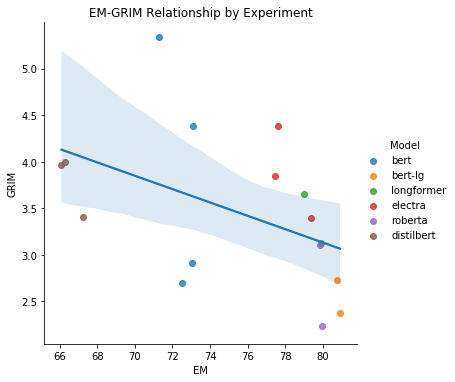

In [43]:
sns.lmplot(x='EM',y='GRIM',data=metrics, hue='Model', scatter=True ,fit_reg=False)
ax2 = ax.twinx()
sns.regplot(x='EM',y='GRIM',data=metrics,scatter=False)#, hue='Model')

plt.title("EM-GRIM Relationship by Experiment")
#plt.legend(labels=["Answerable questions","All questions"])
plt.xlabel('EM')
plt.ylabel('GRIM')
plt.savefig('../assets/EM_vs_GRIM_correlation.png',dpi=300,bbox_inches='tight')

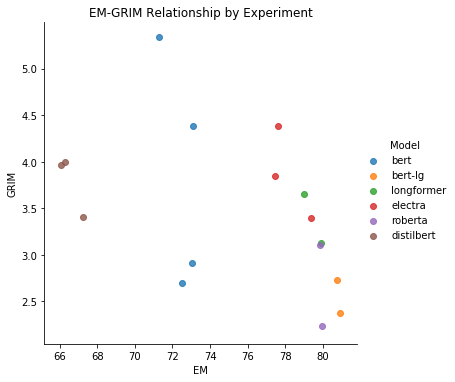

In [44]:
sns.lmplot(x='EM',y='GRIM',data=metrics, hue='Model', scatter=True ,fit_reg=False)
#ax2 = ax.twinx()
#sns.regplot(x='EM',y='GRIM',data=metrics,scatter=False)#, hue='Model')

plt.title("EM-GRIM Relationship by Experiment")
#plt.legend(labels=["Answerable questions","All questions"])
plt.xlabel('EM')
plt.ylabel('GRIM')
plt.savefig('../assets/EM_vs_GRIM_scatter.png',dpi=300,bbox_inches='tight')

# Clustering of Examples by Model Performance

In [45]:
grs = grls_np # GR by example X experiment
grs_na = grls_np[:,list(nas_np[0,:])]
grs_ans = grls_np[:,list(nas_np[0,:]==0)]
grs_means = [np.mean(x) for x in grs.T]
grs_na_means = [np.mean(x) for x in grs_na.T]
grs_ans_means = [np.mean(x) for x in grs_ans.T]
grs_std = [np.std(x) for x in grs.T]
grs_na_std = [np.std(x) for x in grs_na.T]
grs_ans_std = [np.std(x) for x in grs_ans.T]
grs_pr = grls_np[:,list(np.min(grls_np,axis=0) == 0)]

#grs_pr_na = grls_np[:,list(np.min(grls_np,axis=0) == 0 and nas_np[0,:])]

grs_sec = grls_np[:,list(np.min(grls_np,axis=0) > 0)]
grs_pr_means = [np.mean(x) for x in grs_pr.T]
grs_pr_std = [np.std(x) for x in grs_pr.T]
grs_sec_means = [np.mean(x) for x in grs_sec.T]
grs_sec_std = [np.std(x) for x in grs_sec.T]


In [46]:
print("na",len(grs_na_means))
print("ans",len(grs_ans_means))
print("all",grs.shape)



na 5945
ans 5928
all (16, 11873)


In [47]:
X = np.max(grls_np,axis=0)
XX = np.sum(grls_np<10,axis=1)
X10 = np.sum(X<10)
XX10 = np.mean(XX)
print(XX10)
m = X.shape[0]
print(X.shape)
print('There are %i examples (%.2f) that are consistently under rank 10'%(X10,X10/m*100))
print('The average experiment has %i examples (%.2f)%% under rank 10'% (XX10,XX10/m*100))
print('The best experiment has %i examples (%.2f)%% under rank 10'% (np.max(XX),np.max(XX)/m*100))

10969.875
(11873,)
There are 8576 examples (72.23) that are consistently under rank 10
The average experiment has 10969 examples (92.39)% under rank 10
The best experiment has 11418 examples (96.17)% under rank 10


## GR Mean & std of All experiments by Example

We plot the 16 experiment golden rank mean vs. the standard deviation for each example. The first plot below distinguishes the examples into two categories: The gray points denote those examples predicted  correctly by at least one experiment. The blue points denote the rest of the examples that only appeared in secondary predictions.

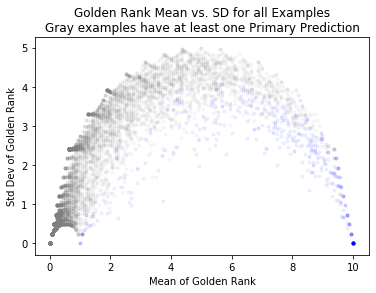

In [48]:
plt.scatter(grs_pr_means,grs_pr_std,alpha = 0.05, marker = '.',color = 'grey')
plt.scatter(grs_sec_means,grs_sec_std,alpha = 0.05, marker = '.',color = 'blue')
plt.xlabel("Mean of Golden Rank")
plt.ylabel("Std Dev of Golden Rank")
plt.title("Golden Rank Mean vs. SD for all Examples\nGray examples have at least one Primary Prediction")
plt.savefig('../assets/GR_mean_vs_std_Predicted_by_at_least_one_model.png',dpi=300)

The following statistics pertain to examples that have been predicted correctly at least once:

In [49]:
m=grls_np.shape[1]
pr_na = np.sum([ a and b for (a,b) in zip(nas_np[0,:],np.min(grls_np,axis=0) == 0) ])
pr_ans = np.sum([ not a and b for (a,b) in zip(nas_np[0,:],np.min(grls_np,axis=0) == 0) ])
pr = np.sum(np.min(grls_np,axis=0) == 0)
print('Total number of examples:',m)
print ('There are %i examples that have been predicted correctly by at leat one experiment' % pr)
print('They are about evenly split between answerable (%i) and unanswearable (%i) examples'% (pr_ans,pr_na))
print ('The remaining %i examples (%.2f%%) are the only ones that appear exclusively in secondary predictions and none of the primary' %\
    (m-pr, (m-pr)/m*100))


Total number of examples: 11873
There are 11397 examples that have been predicted correctly by at leat one experiment
They are about evenly split between answerable (5651) and unanswearable (5746) examples
The remaining 476 examples (4.01%) are the only ones that appear exclusively in secondary predictions and none of the primary


The second graph shows the same mean-standard deviation plot for each example, in green for answerable examples and  red for those that have no answer.The answerable examples are more consistently predicted by the 16 models and remain closer to the higher ranking predictions (towards 0) while the no-answer examples are predicted less successfully and with wider variability.

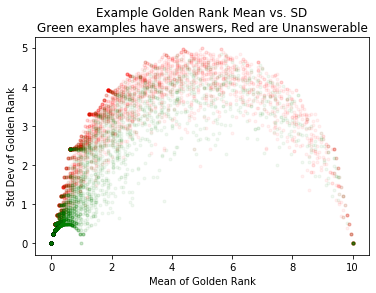

In [50]:
plt.scatter(grs_na_means,grs_na_std,alpha = 0.05, marker = '.',color = 'red')
plt.scatter(grs_ans_means,grs_ans_std,alpha = 0.05, marker = '.',color = 'green')
plt.xlabel("Mean of Golden Rank")
plt.ylabel("Std Dev of Golden Rank")
plt.title("Example Golden Rank Mean vs. SD\nGreen examples have answers, Red are Unanswerable")
plt.savefig('../assets/GR_mean_vs_std_ans_vs_noAns.png',dpi=300)

The following experiment counts correspond to the three points with zero standard deviation. These denote examples that have been consistently ranked for all 15 experiments.

In [51]:
m = len(grs_means)
print('Examples ranked 0 for all experiments: %i or %.2f%%'%(np.sum([x==0 for x in grs_means]),np.sum([x==0 for x in grs_means])/m*100))
print('Examples ranked 10 or higher for all experiments: %i or %.2f%%'%(np.sum([x==10 for x in grs_means]),np.sum([x==10 for x in grs_means])/m*100))
v01 = np.sum([x==0 for x in grs_std])-np.sum([x==10 for x in grs_means])-np.sum([x==0 for x in grs_means])
print('Examples ranked 1 for all experiments: %i or %.2f%%' % (v01,v01/m*100))
print('Examples ranked 0 for all experiments with no answer: %i or %.2f%%'%(np.sum([x==0 for x in grs_na_means]),np.sum([x==0 for x in grs_na_means])/m*100))
print('Examples ranked 10 or higher for all experiments with no answer: %i or %.2f%%'%(np.sum([x==10 for x in grs_na_means]),np.sum([x==10 for x in grs_na_means])/m*100))
v11 = np.sum([x==0 for x in grs_na_std])-np.sum([x==10 for x in grs_na_means])-np.sum([x==0 for x in grs_na_means])
print('Examples ranked 1 for all experiments with no answer: %i or %.2f%%'%(v11,v11/m*100))
print('Examples ranked 0 for all answerable experiments: %i or %.2f%%'%(np.sum([x==0 for x in grs_ans_means]),np.sum([x==0 for x in grs_ans_means])/m*100))
print('Examples ranked 10 or higher for all answerable experiments: %i or %.2f%%'%(np.sum([x==10 for x in grs_ans_means]),np.sum([x==10 for x in grs_ans_means])/m*100))
v21=np.sum([x==0 for x in grs_ans_std])-np.sum([x==10 for x in grs_ans_means])-np.sum([x==0 for x in grs_ans_means])
print('Examples ranked 1 for all answerable experiments: %i or %.2f%%'%(v21,v21/m*100))



#grs.shape

Examples ranked 0 for all experiments: 4654 or 39.20%
Examples ranked 10 or higher for all experiments: 44 or 0.37%
Examples ranked 1 for all experiments: 4 or 0.03%
Examples ranked 0 for all experiments with no answer: 2538 or 21.38%
Examples ranked 10 or higher for all experiments with no answer: 24 or 0.20%
Examples ranked 1 for all experiments with no answer: 0 or 0.00%
Examples ranked 0 for all answerable experiments: 2116 or 17.82%
Examples ranked 10 or higher for all answerable experiments: 20 or 0.17%
Examples ranked 1 for all answerable experiments: 4 or 0.03%


In [52]:
from IPython.display import display, HTML

def wrap_df_text(df):
    return display(HTML(df.to_html().replace("\\n","<br>")))


## Error Analysis - Clusters of Interest

### Four rank-1, sdv-0 examples
The next cell produces the four examples that rank 1 for all experiments. The result shows that three of them involve an incorrect "No Answer" prediction and one looks like an aberration in the golden answers where the returned rank-0 answer should be a correct answer. 

In [53]:
df = RS.topNPredsDF()#topK=5)#, experimentIdx =experimentID)
df['experiment'] = [abbrevLabel[exp] for exp in df['experiment']]
df['id_short'] = [i[20:] for i in df['id']]

In [54]:
pd.set_option('display.max_colwidth', 0)
[(x,y) for x,y in zip(grs_std,grs_means) if x ==0 and y == 1]#)-np.sum([x==10 for x in grs_means])-np.sum([x==0 for x in grs_means])
ixs = np.where(np.prod(grs,axis=0)==1)[0].tolist()
print(ixs)
ids = [x['id'] for i,x in enumerate(raw_datasets['validation']) if i in np.where(np.prod(grs,axis=0)==1)[0].tolist()]
print(ids)
df1 = df.loc[df.id.isin(ids)][['text','probability','id_short','rank','goldAns','correct']]
with open('../assets/errors_GR1_example_predictions_4.tex','w') as F:
    F.write(df1.query('rank < 2').to_latex(index=False))
display( df1.query('rank < 2'))



[4425, 5088, 5557, 5860]
['57263c78ec44d21400f3dc7c', '57267d52708984140094c7da', '5728dc2d3acd2414000e0080', '572742bd5951b619008f8787']


,text,probability,id_short,rank,goldAns,correct
46383,,0.999946,dc7c,0,"[division of functions and tasks between the hosts at the edge of the network and the network core, Two fundamental differences involved the division of functions and tasks between the hosts at the edge of the network and the network core, the division of functions and tasks between the hosts at the edge of the network and the network core.]",False
46384,Two fundamental differences involved the division of functions and tasks between the hosts at the edge of the network and the network core,0.000045,dc7c,1,"[division of functions and tasks between the hosts at the edge of the network and the network core, Two fundamental differences involved the division of functions and tasks between the hosts at the edge of the network and the network core, the division of functions and tasks between the hosts at the edge of the network and the network core.]",True
53241,microscopic analysis of oriented thin sections of geologic samples,0.518779,c7da,0,"[microscopic analysis, use microscopic analysis of oriented thin sections of geologic samples, microscopic analysis of oriented thin sections]",False
53242,microscopic analysis,0.481057,c7da,1,"[microscopic analysis, use microscopic analysis of oriented thin sections of geologic samples, microscopic analysis of oriented thin sections]",True
58120,,1.000000,0080,0,[Brownlee],False
...,...,...,...,...,...,...
2948090,microscopic analysis of oriented thin sections,0.200961,c7da,1,"[microscopic analysis, use microscopic analysis of oriented thin sections of geologic samples, microscopic analysis of oriented thin sections]",True
2952926,,0.996014,0080,0,[Brownlee],False
2952927,Brownlee,0.003980,0080,1,[Brownlee],True
2956002,,0.995019,8787,0,"[waste, a lot of waste]",False


### Sample of highly polarized examples

In [55]:
pd.set_option('display.max_colwidth', 0)
ixs=[(i,mu,std) for i,(mu,std) in enumerate(zip(grs_means,grs_std)) if std> 4.8  ]#)-np.sum([x==10 for x in grs_means])-np.sum([x==0 for x in grs_means])
ixs = [exs[0] for exs in random.sample(ixs,5)]
ids = [x['id'] for i,x in enumerate(raw_datasets['validation']) if i in ixs]
print(ids)
for id in ids:
    print('Example ID:',id)
    print(RS.dataset[RS.ix_id[id]])
    df1 = df.query('id == @id and (rank < 2 or correct == True)')
    #df1 = df.loc[(df.id==id & (df.rank == 0 or df.correct == True))]
    #df1['experiment'] = [abbrevLabel[exp] for exp in df1['experiment']]
    for experimentID in range(16):
        #[RS.topNPreds()[1][id][0] for id in ids]
        #df1['id'] = [i[20:] for i in df1['id']]
        df2 = df1[['text','probability','experiment','rank','goldAns','correct']]
        #wrap_df_text(df1)
    with open('../assets/errors_GR_polar_by_experiment_id_%s.tex'%id,'w') as F:
        F.write(df2.to_latex(index=False))
    display( df2)#.query('rank < 5'))

['5705fec152bb89140068977b', '5ad0475c77cf76001a686f87', '5acfab5077cf76001a6857d3', '5ad407de604f3c001a3ffebd', '5ad4da795b96ef001a10a3e6']
Example ID: 5705fec152bb89140068977b
{'id': '5705fec152bb89140068977b', 'title': 'Southern_California', 'context': 'Each year, the southern California area has about 10,000 earthquakes. Nearly all of them are so small that they are not felt. Only several hundred are greater than magnitude 3.0, and only about 15–20 are greater than magnitude 4.0. The magnitude 6.7 1994 Northridge earthquake was particularly destructive, causing a substantial number of deaths, injuries, and structural collapses. It caused the most property damage of any earthquake in U.S. history, estimated at over $20 billion.', 'question': 'Generally speaking, what size are the earthquakes that hit southern California?', 'answers': {'text': ['small', 'small', 'small'], 'answer_start': [96, 96, 96]}}


,text,probability,experiment,rank,goldAns,correct
8172,"about 10,000",0.872122,bert-uc/001,0,[small],False
8173,"10,000",0.124337,bert-uc/001,1,[small],False
132212,small,0.502760,bert-uc/007,0,[small],True
132213,Nearly all of them are so small,0.363316,bert-uc/007,1,[small],False
325775,small,0.424558,bert-uc/009,0,[small],True
325776,Nearly all of them are so small,0.179215,bert-uc/009,1,[small],False
1443981,small,0.362284,bert-uc/010,0,[small],True
1443982,"10,000 earthquakes. Nearly all of them are so small",0.300891,bert-uc/010,1,[small],False
1566117,Nearly all of them are so small,0.548742,bert-lg-cas-wwm/003,0,[small],False
1566118,small,0.119409,bert-lg-cas-wwm/003,1,[small],True


Example ID: 5ad0475c77cf76001a686f87
{'id': '5ad0475c77cf76001a686f87', 'title': 'Southern_California', 'context': 'The San Bernardino-Riverside area maintains the business districts of Downtown San Bernardino, Hospitality Business/Financial Centre, University Town which are in San Bernardino and Downtown Riverside.', 'question': 'What business districts does the Riverside area maintain?', 'answers': {'text': [], 'answer_start': []}}


,text,probability,experiment,rank,goldAns,correct
9089,"Downtown San Bernardino, Hospitality Business/Financial Centre, University Town",9.864805e-01,bert-uc/001,0,[],False
9090,"Downtown San Bernardino, Hospitality Business/Financial Centre,",6.450134e-03,bert-uc/001,1,[],False
9099,,1.584667e-05,bert-uc/001,10,[],True
133129,"Downtown San Bernardino, Hospitality Business/Financial Centre, University Town",7.474917e-01,bert-uc/007,0,[],False
133130,"Downtown San Bernardino, Hospitality Business/Financial Centre, University Town which are in San Bernardino and Downtown Riverside.",9.380028e-02,bert-uc/007,1,[],False
133139,,3.819045e-05,bert-uc/007,10,[],True
334484,,9.991357e-01,bert-uc/009,0,[],True
334485,Downtown San Bernardino,5.052141e-04,bert-uc/009,1,[],False
334556,",",5.266021e-08,bert-uc/009,72,[],True
1444886,"Downtown San Bernardino, Hospitality Business/Financial Centre, University Town",8.672999e-01,bert-uc/010,0,[],False


Example ID: 5acfab5077cf76001a6857d3
{'id': '5acfab5077cf76001a6857d3', 'title': 'University_of_Chicago', 'context': 'Past faculty have also included Egyptologist James Henry Breasted, mathematician Alberto Calderón, Nobel prize winning economist and classical liberalism defender Friedrich Hayek, meteorologist Ted Fujita, chemists Glenn T. Seaborg, the developer of the actinide concept and Nobel Prize winner Yuan T. Lee, Nobel Prize winning novelist Saul Bellow, political philosopher and author Allan Bloom, cancer researchers Charles Brenton Huggins and Janet Rowley, astronomer Gerard Kuiper, one of the most important figures in the early development of the discipline of linguistics Edward Sapir, and the founder of McKinsey & Co., James O. McKinsey.', 'question': 'What Nobel Prize researchers are former faculty members?', 'answers': {'text': [], 'answer_start': []}}


,text,probability,experiment,rank,goldAns,correct
78972,Charles Brenton Huggins and Janet Rowley,9.751387e-01,bert-uc/001,0,[],False
78973,"Charles Brenton Huggins and Janet Rowley,",1.874609e-02,bert-uc/001,1,[],False
78982,,3.351535e-08,bert-uc/001,10,[],True
202678,Charles Brenton Huggins and Janet Rowley,8.655798e-01,bert-uc/007,0,[],False
202679,cancer researchers Charles Brenton Huggins and Janet Rowley,1.224350e-01,bert-uc/007,1,[],False
202688,,3.234773e-06,bert-uc/007,10,[],True
1004032,Charles Brenton Huggins and Janet Rowley,9.825875e-01,bert-uc/009,0,[],False
1004033,cancer researchers Charles Brenton Huggins and Janet Rowley,3.920951e-03,bert-uc/009,1,[],False
1004062,,1.242270e-05,bert-uc/009,30,[],True
1513608,"Egyptologist James Henry Breasted, mathematician Alberto Calderón",2.555352e-01,bert-uc/010,0,[],False


Example ID: 5ad407de604f3c001a3ffebd
{'id': '5ad407de604f3c001a3ffebd', 'title': 'Yuan_dynasty', 'context': "The Yuan undertook extensive public works. Among Kublai Khan's top engineers and scientists was the astronomer Guo Shoujing, who was tasked with many public works projects and helped the Yuan reform the lunisolar calendar to provide an accuracy of 365.2425 days of the year, which was only 26 seconds off the modern Gregorian calendar's measurement. Road and water communications were reorganized and improved. To provide against possible famines, granaries were ordered built throughout the empire. The city of Beijing was rebuilt with new palace grounds that included artificial lakes, hills and mountains, and parks. During the Yuan period, Beijing became the terminus of the Grand Canal of China, which was completely renovated. These commercially oriented improvements encouraged overland and maritime commerce throughout Asia and facilitated direct Chinese contacts with Europe. Chines

,text,probability,experiment,rank,goldAns,correct
81755,granaries were ordered built,8.655204e-01,bert-uc/001,0,[],False
81756,built,1.002482e-01,bert-uc/001,1,[],False
81765,,1.590421e-12,bert-uc/001,10,[],True
205434,granaries were ordered built,7.647477e-01,bert-uc/007,0,[],False
205435,granaries,2.125247e-01,bert-uc/007,1,[],False
205444,,2.535206e-08,bert-uc/007,10,[],True
1030204,granaries,4.853834e-01,bert-uc/009,0,[],False
1030205,granaries were ordered built,2.109390e-01,bert-uc/009,1,[],False
1030304,,9.841911e-08,bert-uc/009,100,[],True
1516337,granaries were ordered built throughout the empire,5.122722e-01,bert-uc/010,0,[],False


Example ID: 5ad4da795b96ef001a10a3e6
{'id': '5ad4da795b96ef001a10a3e6', 'title': 'Warsaw', 'context': 'There are also many places commemorating the heroic history of Warsaw. Pawiak, an infamous German Gestapo prison now occupied by a Mausoleum of Memory of Martyrdom and the museum, is only the beginning of a walk in the traces of Heroic City. The Warsaw Citadel, an impressive 19th-century fortification built after the defeat of the November Uprising, was a place of martyr for the Poles. Another important monument, the statue of Little Insurgent located at the ramparts of the Old Town, commemorates the children who served as messengers and frontline troops in the Warsaw Uprising, while the impressive Warsaw Uprising Monument by Wincenty Kućma was erected in memory of the largest insurrection of World War II.', 'question': "What commemorates Old Town's heroic history?", 'answers': {'text': [], 'answer_start': []}}


,text,probability,experiment,rank,goldAns,correct
113052,statue of Little Insurgent,9.525250e-01,bert-uc/001,0,[],False
113053,the statue of Little Insurgent,4.630980e-02,bert-uc/001,1,[],False
113062,,1.975499e-11,bert-uc/001,10,[],True
236575,statue of Little Insurgent,9.273499e-01,bert-uc/007,0,[],False
236576,the statue of Little Insurgent,6.667584e-02,bert-uc/007,1,[],False
236585,,1.827411e-10,bert-uc/007,10,[],True
1329668,statue of Little Insurgent,6.565378e-01,bert-uc/009,0,[],False
1329669,the statue of Little Insurgent,3.035555e-01,bert-uc/009,1,[],False
1329697,the,1.223392e-05,bert-uc/009,29,[],True
1329768,,4.482339e-10,bert-uc/009,100,[],True


### Polarized Answerable Examples

In [56]:
pd.set_option('display.max_colwidth', 0)
ixs=[(i,mu,std) for i,(mu,std) in enumerate(zip(grs_means,grs_std)) if std> 4.5  ]#)-np.sum([x==10 for x in grs_means])-np.sum([x==0 for x in grs_means])
ixs = [x[0] for x in random.sample(ixs,40)]
ids = [x['id'] for i,x in enumerate(raw_datasets['validation']) if i in ixs and x['answers']['text'] != []]
print(ids)
for id in ids:
    print('Example ID:',id)
    df1 = df.query('id == @id and (rank < 2 or correct == True)')
    #df1 = df.loc[(df.id==id & (df.rank == 0 or df.correct == True))]
    for experimentID in range(16):
        #[RS.topNPreds()[1][id][0] for id in ids]
        #df1['id'] = [i[20:] for i in df1['id']]
        df2 = df1[['text','probability','experiment','rank','goldAns','correct']]
        #wrap_df_text(df1)
    with open('../assets/errors_GR_polar_answerable_%s.tex'%id,'w') as F:
        F.write(df2.query('rank < 5').to_latex(index=False))
    display( df2)#.query('rank < 5'))

['571cb27fdd7acb1400e4c133', '572647e2dd62a815002e805e', '572820512ca10214002d9e72', '572a13841d0469140077973c', '572881704b864d1900164a51']
Example ID: 571cb27fdd7acb1400e4c133


,text,probability,experiment,rank,goldAns,correct
26251,ice core,0.814572,bert-uc/001,0,"[what the climate was like millions of years ago, climate, temperatures]",False
26252,ice core samples that are up to several hundreds of thousands of years old.,0.045771,bert-uc/001,1,"[what the climate was like millions of years ago, climate, temperatures]",False
150233,,0.990861,bert-uc/007,0,"[what the climate was like millions of years ago, climate, temperatures]",False
150234,"lower global temperatures, snow and rain",0.005701,bert-uc/007,1,"[what the climate was like millions of years ago, climate, temperatures]",False
498198,snow and rain,0.454572,bert-uc/009,0,"[what the climate was like millions of years ago, climate, temperatures]",False
498199,"lower global temperatures, snow and rain",0.235187,bert-uc/009,1,"[what the climate was like millions of years ago, climate, temperatures]",False
498211,the climate,0.002892,bert-uc/009,13,"[what the climate was like millions of years ago, climate, temperatures]",True
498215,climate,0.002315,bert-uc/009,17,"[what the climate was like millions of years ago, climate, temperatures]",True
498232,temperatures,0.000441,bert-uc/009,34,"[what the climate was like millions of years ago, climate, temperatures]",True
1461739,Seawater,0.318287,bert-uc/010,0,"[what the climate was like millions of years ago, climate, temperatures]",False


Example ID: 572647e2dd62a815002e805e


,text,probability,experiment,rank,goldAns,correct
48166,link researchers to the nation's NSF-funded supercomputing centers,0.692433,bert-uc/001,0,"[it developed into a major part of the Internet backbone, a major part of the Internet backbone, major part of the Internet backbone]",False
48167,Initially created to link researchers to the nation's NSF-funded supercomputing centers,0.136927,bert-uc/001,1,"[it developed into a major part of the Internet backbone, a major part of the Internet backbone, major part of the Internet backbone]",False
172070,link researchers to the nation's NSF-funded supercomputing centers,0.388653,bert-uc/007,0,"[it developed into a major part of the Internet backbone, a major part of the Internet backbone, major part of the Internet backbone]",False
172071,to link researchers to the nation's NSF-funded supercomputing centers,0.234792,bert-uc/007,1,"[it developed into a major part of the Internet backbone, a major part of the Internet backbone, major part of the Internet backbone]",False
707696,link researchers to the nation's NSF-funded supercomputing centers,0.134174,bert-uc/009,0,"[it developed into a major part of the Internet backbone, a major part of the Internet backbone, major part of the Internet backbone]",False
707697,Initially created to link researchers to the nation's NSF-funded supercomputing centers,0.110862,bert-uc/009,1,"[it developed into a major part of the Internet backbone, a major part of the Internet backbone, major part of the Internet backbone]",False
707699,it developed into a major part of the Internet backbone,0.096187,bert-uc/009,3,"[it developed into a major part of the Internet backbone, a major part of the Internet backbone, major part of the Internet backbone]",True
707705,it developed into a major part of the Internet backbone.,0.023823,bert-uc/009,9,"[it developed into a major part of the Internet backbone, a major part of the Internet backbone, major part of the Internet backbone]",True
707715,major part of the Internet backbone,0.009069,bert-uc/009,19,"[it developed into a major part of the Internet backbone, a major part of the Internet backbone, major part of the Internet backbone]",True
707722,a major part of the Internet backbone,0.005089,bert-uc/009,26,"[it developed into a major part of the Internet backbone, a major part of the Internet backbone, major part of the Internet backbone]",True


Example ID: 572820512ca10214002d9e72


,text,probability,experiment,rank,goldAns,correct
69389,"86.66% (757.7 sq mi or 1,962 km2)",9.986784e-01,bert-uc/001,0,[874.3 square miles],False
69390,86.66%,1.317464e-03,bert-uc/001,1,[874.3 square miles],False
193139,86.66%,9.940925e-01,bert-uc/007,0,[874.3 square miles],False
193140,"86.66% (757.7 sq mi or 1,962 km2)",4.393009e-03,bert-uc/007,1,[874.3 square miles],False
911800,86.66%,8.849197e-01,bert-uc/009,0,[874.3 square miles],False
911801,"86.66% (757.7 sq mi or 1,962 km2)",4.577776e-02,bert-uc/009,1,[874.3 square miles],False
911885,874.3 square miles,5.782291e-07,bert-uc/009,85,[874.3 square miles],True
1504157,86.66%,5.100478e-01,bert-uc/010,0,[874.3 square miles],False
1504158,"86.66% (757.7 sq mi or 1,962 km2)",3.965890e-01,bert-uc/010,1,[874.3 square miles],False
1504163,874.3 square miles,2.843794e-03,bert-uc/010,6,[874.3 square miles],True


Example ID: 572a13841d0469140077973c


,text,probability,experiment,rank,goldAns,correct
74251,increases,6.078096e-01,bert-uc/001,0,"[inequality first increases, first increases, increases]",True
74252,first increases,3.897095e-01,bert-uc/001,1,"[inequality first increases, first increases, increases]",True
74259,inequality first increases,4.814568e-06,bert-uc/001,8,"[inequality first increases, first increases, increases]",True
197993,,9.999981e-01,bert-uc/007,0,"[inequality first increases, first increases, increases]",False
197994,increases,8.456487e-07,bert-uc/007,1,"[inequality first increases, first increases, increases]",True
197995,first increases,4.174591e-07,bert-uc/007,2,"[inequality first increases, first increases, increases]",True
958816,,3.230420e-01,bert-uc/009,0,"[inequality first increases, first increases, increases]",False
958817,"from 1914 to 1945 wars and ""violent economic and political shocks",8.765735e-02,bert-uc/009,1,"[inequality first increases, first increases, increases]",False
958833,first increases,6.399575e-03,bert-uc/009,17,"[inequality first increases, first increases, increases]",True
958845,increases,1.623220e-03,bert-uc/009,29,"[inequality first increases, first increases, increases]",True


Example ID: 572881704b864d1900164a51


,text,probability,experiment,rank,goldAns,correct
82756,the Yuan inherited from the Jin dynasty,0.887328,bert-uc/001,0,[inherited from the Jin dynasty],False
82757,inherited from the Jin dynasty,0.100190,bert-uc/001,1,[inherited from the Jin dynasty],True
206428,the Yuan inherited from the Jin dynasty,0.501200,bert-uc/007,0,[inherited from the Jin dynasty],False
206429,the Yuan inherited from the Jin dynasty.,0.244919,bert-uc/007,1,[inherited from the Jin dynasty],False
1039628,based on the same intellectual foundation,0.180123,bert-uc/009,0,[inherited from the Jin dynasty],False
1039629,"based on the same intellectual foundation, but advocated different theoretical approaches toward medicine",0.145755,bert-uc/009,1,[inherited from the Jin dynasty],False
1039678,inherited from the Jin dynasty.,0.000774,bert-uc/009,50,[inherited from the Jin dynasty],True
1039688,inherited from the Jin dynasty,0.000502,bert-uc/009,60,[inherited from the Jin dynasty],True
1517323,"All four schools were based on the same intellectual foundation, but advocated different theoretical approaches toward medicine",0.257751,bert-uc/010,0,[inherited from the Jin dynasty],False
1517324,All four schools were based on the same intellectual foundation,0.190199,bert-uc/010,1,[inherited from the Jin dynasty],False


### All Experiments in Rank 10+

In [57]:
pd.set_option('display.max_colwidth', 0)
ixs=[(i,mu,std) for i,(mu,std) in enumerate(zip(grs_means,grs_std)) if mu == 10  ]
ixs = [x[0] for x in random.sample(ixs,10)]
ids = [x['id'] for i,x in enumerate(raw_datasets['validation']) if i in ixs and x['answers']['text'] != []]
print(ids)
for id in ids:
    print('Example ID:',id)
    df1 = df.query('id == @id and (rank < 3 or correct == True)')
    #df1 = df.loc[(df.id==id & (df.rank == 0 or df.correct == True))]
    for experimentID in range(16):
        #[RS.topNPreds()[1][id][0] for id in ids]
        #df1['id'] = [i[20:] for i in df1['id']]
        df2 = df1[['text','probability','experiment','rank','goldAns','correct']]
        #wrap_df_text(df1)
    with open('../assets/errors_GR_10_Plus_%s.tex'%id,'w') as F:
        F.write(df2.query('rank < 5').to_latex(index=False))
    display( df2)#.query('rank < 5'))

['571cd703dd7acb1400e4c185', '57269e3bf1498d1400e8e51a', '5728e8212ca10214002daa70', '572fe1d404bcaa1900d76e37', '57308f6b8ab72b1400f9c584']
Example ID: 571cd703dd7acb1400e4c185


,text,probability,experiment,rank,goldAns,correct
27466,chemical bonds with almost all other elements to give corresponding oxides,0.992296,bert-uc/001,0,"[a thin film of oxide, oxide]",False
27467,oxides,0.005971,bert-uc/001,1,"[a thin film of oxide, oxide]",False
27468,oxygen forms chemical bonds with almost all other elements to give corresponding oxides,0.001312,bert-uc/001,2,"[a thin film of oxide, oxide]",False
151447,chemical bonds with almost all other elements to give corresponding oxides,0.878123,bert-uc/007,0,"[a thin film of oxide, oxide]",False
151448,chemical bonds,0.115410,bert-uc/007,1,"[a thin film of oxide, oxide]",False
151449,chemical bonds with almost all other elements,0.002549,bert-uc/007,2,"[a thin film of oxide, oxide]",False
509804,chemical bonds with almost all other elements to give corresponding oxides,0.775446,bert-uc/009,0,"[a thin film of oxide, oxide]",False
509805,chemical bonds,0.097449,bert-uc/009,1,"[a thin film of oxide, oxide]",False
509806,oxides,0.040966,bert-uc/009,2,"[a thin film of oxide, oxide]",False
509845,oxide,0.000028,bert-uc/009,41,"[a thin film of oxide, oxide]",True


Example ID: 57269e3bf1498d1400e8e51a


,text,probability,experiment,rank,goldAns,correct
33061,60,0.992298,bert-uc/001,0,[women retire at age 60 and men at 65],False
33062,60 and men at 65,0.007674,bert-uc/001,1,[women retire at age 60 and men at 65],False
33063,65,0.000026,bert-uc/001,2,[women retire at age 60 and men at 65],False
157043,60,0.983167,bert-uc/007,0,[women retire at age 60 and men at 65],False
157044,60 and men at 65,0.008183,bert-uc/007,1,[women retire at age 60 and men at 65],False
157045,age 60,0.005479,bert-uc/007,2,[women retire at age 60 and men at 65],False
563076,60,0.435714,bert-uc/009,0,[women retire at age 60 and men at 65],False
563077,60 and men at 65,0.231683,bert-uc/009,1,[women retire at age 60 and men at 65],False
563078,65,0.164138,bert-uc/009,2,[women retire at age 60 and men at 65],False
563106,women retire at age 60 and men at 65,0.000077,bert-uc/009,30,[women retire at age 60 and men at 65],True


Example ID: 5728e8212ca10214002daa70


,text,probability,experiment,rank,goldAns,correct
59306,fear of seeming rude,9.862454e-01,bert-uc/001,0,"[civil disobedience, to make an impression, use the arrest as an opportunity]",False
59307,a fear of seeming rude,8.791068e-03,bert-uc/001,1,"[civil disobedience, to make an impression, use the arrest as an opportunity]",False
59308,due to a fear of seeming rude,4.519673e-03,bert-uc/001,2,"[civil disobedience, to make an impression, use the arrest as an opportunity]",False
183119,,9.715560e-01,bert-uc/007,0,"[civil disobedience, to make an impression, use the arrest as an opportunity]",False
183120,"a lack of understanding of the legal ramifications, or due to a fear of seeming rude",1.650793e-02,bert-uc/007,1,"[civil disobedience, to make an impression, use the arrest as an opportunity]",False
183121,"lack of understanding of the legal ramifications, or due to a fear of seeming rude",6.719843e-03,bert-uc/007,2,"[civil disobedience, to make an impression, use the arrest as an opportunity]",False
815039,"lack of understanding of the legal ramifications, or due to a fear of seeming rude",2.595226e-01,bert-uc/009,0,"[civil disobedience, to make an impression, use the arrest as an opportunity]",False
815040,,2.320498e-01,bert-uc/009,1,"[civil disobedience, to make an impression, use the arrest as an opportunity]",False
815041,fear of seeming rude,1.327194e-01,bert-uc/009,2,"[civil disobedience, to make an impression, use the arrest as an opportunity]",False
1494242,"lack of understanding of the legal ramifications, or due to a fear of seeming rude",3.719857e-01,bert-uc/010,0,"[civil disobedience, to make an impression, use the arrest as an opportunity]",False


Example ID: 572fe1d404bcaa1900d76e37


,text,probability,experiment,rank,goldAns,correct
94212,Swiss canton of Graubünden in the southeastern Swiss Alps,0.694710,bert-uc/001,0,"[Europe, Germany, Central and Western Europe]",False
94213,Swiss canton of Graubünden,0.226106,bert-uc/001,1,"[Europe, Germany, Central and Western Europe]",False
94214,the southeastern Swiss Alps,0.022725,bert-uc/001,2,"[Europe, Germany, Central and Western Europe]",False
217799,Rhineland,0.564150,bert-uc/007,0,"[Europe, Germany, Central and Western Europe]",False
217800,through the Rhineland,0.320290,bert-uc/007,1,"[Europe, Germany, Central and Western Europe]",False
217801,Rhineland and eventually empties into the North Sea in the Netherlands,0.053152,bert-uc/007,2,"[Europe, Germany, Central and Western Europe]",False
1149131,Swiss canton of Graubünden,0.490557,bert-uc/009,0,"[Europe, Germany, Central and Western Europe]",False
1149132,Swiss canton of Graubünden in the southeastern Swiss Alps,0.320641,bert-uc/009,1,"[Europe, Germany, Central and Western Europe]",False
1149133,Graubünden,0.060750,bert-uc/009,2,"[Europe, Germany, Central and Western Europe]",False
1528560,Swiss canton of Graubünden in the southeastern Swiss Alps,0.470771,bert-uc/010,0,"[Europe, Germany, Central and Western Europe]",False


Example ID: 57308f6b8ab72b1400f9c584


,text,probability,experiment,rank,goldAns,correct
108162,inferior,0.997200,bert-uc/001,0,"[progressive, rational and progressive]",False
108163,"irrational and backward in opposition to the rational and progressive West. Defining the East as a negative vision of itself, as its inferior",0.002148,bert-uc/001,1,"[progressive, rational and progressive]",False
108164,"backward in opposition to the rational and progressive West. Defining the East as a negative vision of itself, as its inferior",0.000629,bert-uc/001,2,"[progressive, rational and progressive]",False
231660,inferior,0.950693,bert-uc/007,0,"[progressive, rational and progressive]",False
231661,"negative vision of itself, as its inferior",0.030625,bert-uc/007,1,"[progressive, rational and progressive]",False
231662,its inferior,0.008971,bert-uc/007,2,"[progressive, rational and progressive]",False
1282905,inferior,0.217957,bert-uc/009,0,"[progressive, rational and progressive]",False
1282906,"negative vision of itself, as its inferior",0.187377,bert-uc/009,1,"[progressive, rational and progressive]",False
1282907,"a negative vision of itself, as its inferior",0.138961,bert-uc/009,2,"[progressive, rational and progressive]",False
1282996,rational and progressive,0.000017,bert-uc/009,91,"[progressive, rational and progressive]",True


# K-Rank majority Ensemble

Instead of considering the majority of top choices, consider the majority of the top K ranks

## Selecting the Experiments

We select the experiments with the lowest GRIM

In [58]:
L = [i for i in range(len(RS.labels)) if '/na/' not in RS.labels[i]]
print(L)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [59]:
eSel = np.argsort([-1*metrics['EM'][i] for i in L ])[:5]
eSel = [L[i] for i in eSel] 
print(eSel)
[RS.labels[i] for i in eSel]

[5, 4, 12, 7, 11]


['bert-lg-uc-wwm-sq2/001',
 'bert-lg-cas-wwm/003',
 'roberta-sq2/002',
 'longformer-sq2/011',
 'roberta-sq2/001']

In [60]:
eSel = np.argsort([medians[i] for i in L ])[:5]
eSel = [L[i] for i in eSel] 
print(eSel)
[RS.labels[i] for i in eSel]

[12, 5, 3, 4, 2]


['roberta-sq2/002',
 'bert-lg-uc-wwm-sq2/001',
 'bert-uc/010',
 'bert-lg-cas-wwm/003',
 'bert-uc/009']

We then extract the topK answers from each of these models

In [61]:
K = 1
ansDict = {}
for expId in eSel:
    E = RS.topNPreds(experimentIdx=expId)[0]
    #print(len(E))
    for k,v in E.items():
        #print(k)
        if k not in ansDict:
            ansDict[k] = []
        for x in v :
            #print(x)
            if x['rank'] < K:
                ansDict[k].append(x['text'])
            else:
                break

predDict = {}
for k,l in ansDict.items():
    predDict[k] = max(l,key=l.count)
print(len(predDict))
print(len(ansDict))

11873
11873


In [62]:
res_EM = []
res_F1 = []
for k,p in predDict.items():
    answers = RS.dataset[RS.ix_id[k]]['answers']['text']
    if answers:
        res_EM.append(any([compute_em(a,p) for a in answers]))
        res_F1.append(any([compute_f1(a,p) for a in answers]))
    else:
        res_EM.append(normalize_answer(p) == '')
        res_F1.append(normalize_answer(p) == '')
print('EM =',sum(res_EM)/len(res_EM)*100)
print('F1 = ',sum(res_F1)/len(res_F1)*100)

EM = 81.75692748252337
F1 =  85.7323338667565


The best results are with K=1 and using the ensemble of the 5 lowest GRIM experiments.

In [63]:
predDict['56ddde6b9a695914005b9628']

'France'

## Other Clustering attempts

/home/farsipal/projects/GITHUB/squadBERT/notebooks/utils_anal.py:440: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Characterization  Counts  fromMeans  toMeans  fromStd    toStd
     All Correct    4654     0.0000   0.0000 0.000000 0.000000
  Mostly Correct    4392     0.0000   4.3125 0.000000 4.635124
       Uncertain     876     0.1875   6.8750 0.726184 4.960784
       Uncertain     892     0.9375   6.6875 1.695582 5.000000
       Uncertain     777     2.3125  10.0000 0.000000 5.000000
       Uncertain     282     2.5000   9.5625 1.456398 4.943035
       All Wrong       0     0.0000   0.0000 0.000000 0.000000


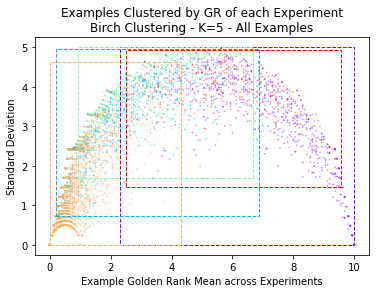

In [64]:
X = grls_np.T
X_means = grs_means
X_std = grs_std
maxBins = maxBins
K_clusters = 5

counts_pd = cluster_examples_by_GR(X = X, X_means= X_means, X_std = X_std, maxBins = maxBins, 
    K_clusters = K_clusters, slice_descr="All Examples", 
    save_path = Path("../assets/").joinpath("cluster5_all") )
with open('../assets/cluster5_all.tex','w') as F:
    F.write(counts_pd.to_latex(index=False))

print(counts_pd.to_string(index=False))


/home/farsipal/projects/GITHUB/squadBERT/notebooks/utils_anal.py:440: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Characterization  Counts  fromMeans  toMeans  fromStd    toStd
     All Correct    4654     0.0000   0.0000 0.000000 0.000000
  Mostly Correct    4392     0.0000   4.3125 0.000000 4.635124
       Uncertain     876     0.1875   6.8750 0.726184 4.960784
       Uncertain     892     0.9375   6.6875 1.695582 5.000000
       Uncertain    1059     2.3125  10.0000 0.000000 5.000000
       All Wrong       0     0.0000   0.0000 0.000000 0.000000


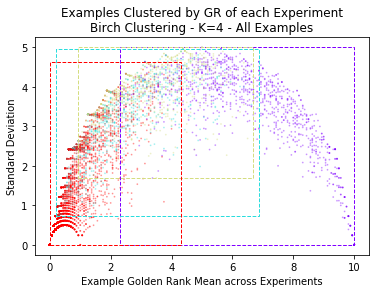

In [65]:
X = grls_np.T
X_means = grs_means
X_std = grs_std
maxBins = maxBins
K_clusters = 4

counts_pd = cluster_examples_by_GR(X = X, X_means= X_means, X_std = X_std, maxBins = maxBins, 
    K_clusters = K_clusters, slice_descr="All Examples", 
    save_path = Path("../assets/").joinpath("cluster4_all") )
with open('../assets/cluster4_all.tex','w') as F:
    F.write(counts_pd.to_latex(index=False))
print(counts_pd.to_string(index=False))


Characterization  Counts  fromMeans  toMeans  fromStd    toStd
     All Correct    2538     0.0000   0.0000 0.000000 0.000000
  Mostly Correct    2420     0.0000   6.4375 0.000000 4.943035
       Uncertain     583     1.1875   8.8750 2.185714 5.000000
       Uncertain     404     3.5000  10.0000 0.000000 4.833154
       All Wrong       0     0.0000   0.0000 0.000000 0.000000


/home/farsipal/projects/GITHUB/squadBERT/notebooks/utils_anal.py:440: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


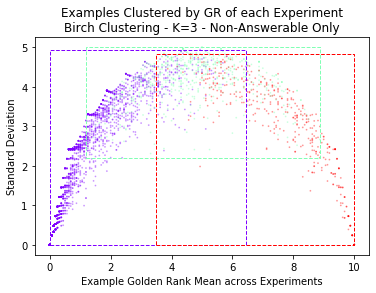

In [66]:
X = grs_na.T
X_means = grs_na_means
X_std = grs_na_std
maxBins = maxBins
K_clusters = 3

counts_pd = cluster_examples_by_GR(X = X, X_means= X_means, X_std = X_std, maxBins = maxBins, 
    K_clusters = K_clusters, slice_descr="Non-Answerable Only", 
    save_path = Path("../assets/").joinpath("cluster3_na") )
with open('../assets/cluster3_na.tex','w') as F:
    F.write(counts_pd.to_latex(index=False))
print(counts_pd.to_string(index=False))


Characterization  Counts  fromMeans  toMeans  fromStd    toStd
     All Correct    2116       0.00   0.0000  0.00000 0.000000
  Mostly Correct    2715       0.00   4.6875  0.00000 4.485654
       Uncertain     541       0.25   5.7500  0.75000 4.639757
       Uncertain     422       1.75   8.1875  1.63936 4.911323
       Uncertain     134       6.25  10.0000  0.00000 4.547922
       All Wrong       0       0.00   0.0000  0.00000 0.000000


/home/farsipal/projects/GITHUB/squadBERT/notebooks/utils_anal.py:440: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


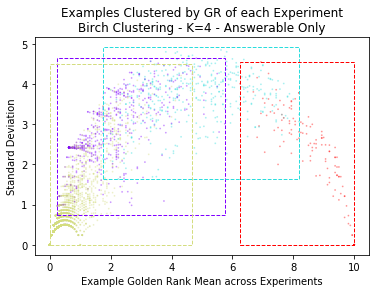

In [95]:
X = grs_ans.T
X_means = grs_ans_means
X_std = grs_ans_std
maxBins = maxBins
K_clusters = 4

counts_pd = cluster_examples_by_GR(X = X, X_means= X_means, X_std = X_std, maxBins = maxBins, 
    K_clusters = K_clusters, slice_descr="Answerable Only", 
    save_path = Path("../assets/").joinpath("cluster4_ans") )
with open('../assets/cluster4_ans.tex','w') as F:
    F.write(counts_pd.to_latex(index=False))
print(counts_pd.to_string(index=False))


Characterization  Counts  fromMeans  toMeans  fromStd    toStd
     All Correct    2116       0.00   0.0000     0.00 0.000000
  Mostly Correct    2715       0.00   4.6875     0.00 4.485654
       Uncertain     541       0.25   5.7500     0.75 4.639757
       Uncertain     556       1.75  10.0000     0.00 4.911323
       All Wrong       0       0.00   0.0000     0.00 0.000000


/home/farsipal/projects/GITHUB/squadBERT/notebooks/utils_anal.py:440: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


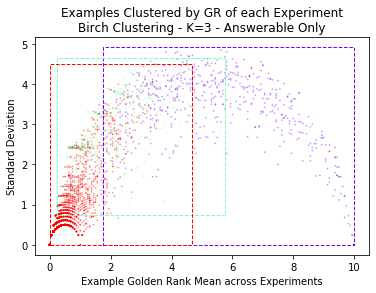

In [96]:
X = grs_ans.T
X_means = grs_ans_means
X_std = grs_ans_std
maxBins = maxBins
K_clusters = 3

counts_pd = cluster_examples_by_GR(X = X, X_means= X_means, X_std = X_std, maxBins = maxBins, 
    K_clusters = K_clusters, slice_descr="Answerable Only", 
    save_path = Path("../assets/").joinpath("cluster3_ans") )
with open('../assets/cluster3_ans.tex','w') as F:
    F.write(counts_pd.to_latex(index=False))
print(counts_pd.to_string(index=False))



## Golden Rank (GR)

The Golden Rank $R$ is the lowest rank in the order of descenting probability of the prediction exactly matching one of the golden answers. 

The output layer of the model yields a vector of start logits and end logits for each example.  These are then passed through masked softmax producing two probability vectors, one for the start marker and another for the end marker. 

The two probability vectors for each example are then combined to form a single probability which is the value provided in the top-N results. The choice of the function that combines the two probabilities to produce the combined probability in the Huggingface implementation is a simple average of the start and end probability. There are other possibilities however:

*   The product of the two probabilities can be used instead of the average (used in the BiDAF starter code) 
*   Taking a weighted average is discussed in various articles, for example in [*Question and Answering on SQuAD 2.0: BERT Is All You Need* by Schwager and Solitario](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/reports/default/15812785.pdf). They argue that the start probability carries more weight than the end probability so weighing the start twice as much as the end may be appropriate.
*  Hyperparameter settings favoring no-answer detection have weaker scores in F1 and exact match detection, and vice versa. This observation was made by the same paper above, and we confirmed it through our own experimentation. 

We now calculate the Golden Rank from the predictions in RS. 

The value maxBins is used to size the histograms to the ranks available in the data.
The topNPreds returns a list of dictionaries, one for each experiment. 
Each of these, are indexed by example ID, and they contain the list of ranked predictions for it. 
We walk down that list and rank the id with the rank of the first correct answer we encounter. If the list goes past the maxBins, the last bin contains the rank that captures the result. If no entry exists with a correct answer, then the default rank will be used.

In [97]:
grls_np, nas_np, maxBinsActual, mediansNonZeroRanks_np, grls = RS.calc_golden_ranks(maxBins = 10)
len(grls[10])

11873

## Mean rank

Smaller is better

In [98]:
np.mean(grls_np,axis=1)



array([1.62840057, 1.451276  , 1.2985766 , 1.24854712, 0.88200118,
       0.81310537, 1.06426345, 0.97186895, 1.13442264, 1.0146551 ,
       1.1908532 , 0.97287964, 0.8026615 , 1.63134844, 1.76130717,
       1.7447149 ])

## Median Rank

In [99]:
[np.median([r  for r in L if r>0]) for L in grls]

[5.0,
 4.0,
 3.0,
 3.0,
 3.0,
 2.0,
 4.0,
 3.0,
 4.0,
 3.0,
 4.0,
 3.0,
 2.0,
 3.0,
 4.0,
 4.0]

## Interpolated Median Rank

In [100]:
[median_grouped([r  for r in L if r>0]) for L in grls]


[5.3396946564885495,
 4.383620689655173,
 2.909090909090909,
 2.7009345794392523,
 2.7260273972602738,
 2.3793650793650793,
 3.65,
 3.125766871165644,
 3.84375,
 3.3986013986013988,
 4.378787878787879,
 3.1099290780141846,
 2.2329376854599405,
 3.4051383399209487,
 3.966824644549763,
 3.994949494949495]

## Scaterplots of Interpolated Median and Mean

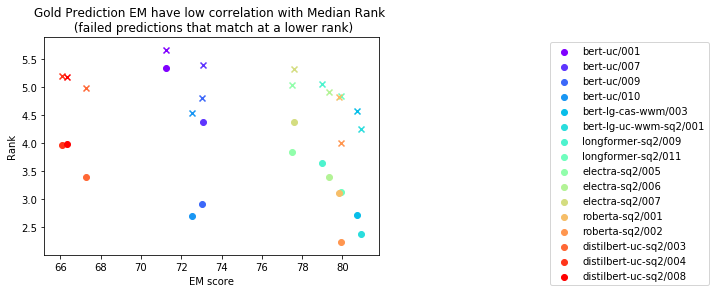

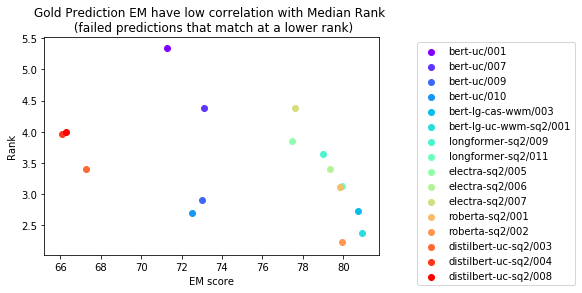

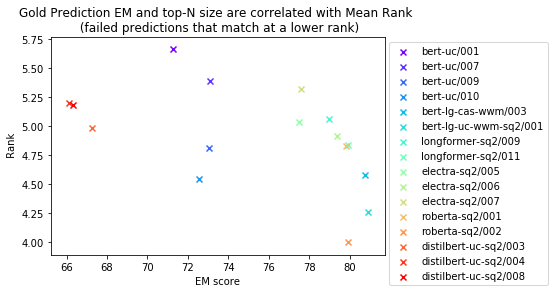

,EM,Median,Mean,labels
0,28.737472,5.339695,5.666471,bert-uc/001
1,26.909795,4.383621,5.393114,bert-uc/007
2,26.968753,2.909091,4.815116,bert-uc/009
3,27.474101,2.700935,4.544451,bert-uc/010
4,19.270614,2.726027,4.576923,bert-lg-cas-wwm/003
5,19.085320,2.379365,4.260371,bert-lg-uc-wwm-sq2/001
6,21.014066,3.650000,5.064529,longformer-sq2/009
7,20.079171,3.125767,4.840185,longformer-sq2/011
8,22.521688,3.843750,5.037023,electra-sq2/005
9,20.643477,3.398601,4.915137,electra-sq2/006


In [101]:
grls = grls #RS.topNPreds(topK=10)
R = []
md = []
mn = []
df = []
score = []
for L in grls:
    M = len(L)
    R = [r for r in L if r > 0]
    #md.append(median_grouped(R))
    #mn.append(np.mean(R))
    #score.append(np.array(R).shape[0]/M*100)
    df.append([np.array(R).shape[0]/M*100,median_grouped(R),np.mean(R)])
#md = np.array(md)
#mn = np.array(mn)
#score = np.array(score)
df = pd.DataFrame(df)
df.columns = ['EM','Median','Mean']
df['labels'] = RS.labels


#plt.scatter(score,md)
#plt.legend(labels=RS.experiments,loc='upper right', bbox_to_anchor=(2, 1))
#plt.title("Gold Pred Rank vs median\n of failed predictions")
#plt.show()

#plt.scatter(score,mn)
#plt.legend(labels=RS.experiments,loc='upper right', bbox_to_anchor=(2, 1))
#plt.title("Gold Pred Rank vs mean\n of failed predictions")
#plt.show()

colors = cm.rainbow(np.linspace(0, 1, len(df)))

#plt.scatter(df.EM,df.Mean,color=colors)
#plt.title("Gold Pred Rank vs median and mean\n of failed predictions")
#plt.legend(labels=df.experiment,loc='upper right', bbox_to_anchor=(2, 1))
#plt.show()

for x, y1,y2, c  in zip(100-df.EM,df.Median, df.Mean ,colors):
    plt.scatter(x, y1, marker='o', color=c)
plt.title("Gold Prediction EM have low correlation with Median Rank \n (failed predictions that match at a lower rank)")
plt.legend(labels=df.labels,loc='upper right', bbox_to_anchor=(2, 1))
plt.xlabel("EM score")
plt.ylabel("Rank")
for x, y1,y2, c  in zip(100-df.EM,df.Median, df.Mean ,colors):
    plt.scatter(x, y2, marker='x', color=c)

plt.show()

for x, y1,y2, c  in zip(100-df.EM,df.Median, df.Mean ,colors):
    plt.scatter(x, y1, marker='o', color=c)
plt.title("Gold Prediction EM have low correlation with Median Rank \n (failed predictions that match at a lower rank)")
plt.legend(labels=df.labels,loc='upper right', bbox_to_anchor=(1.6, 1))
plt.xlabel("EM score")
plt.ylabel("Rank")
plt.show()

for x, y1,y2, c  in zip(100-df.EM,df.Median, df.Mean ,colors):
    plt.scatter(x, y2, marker='x', color=c)
plt.title("Gold Prediction EM and top-N size are correlated with Mean Rank \n (failed predictions that match at a lower rank)")
plt.legend(labels=df.labels,loc='upper right', bbox_to_anchor=(1.5, 1))
plt.xlabel("EM score")
plt.ylabel(" Rank")
plt.show()

df

# Postprocessing and Metrics 
We follow the postprocessing of the question-answering model output from logits to the computation of exact match and F1 metrics. 
These metrics deal with the top prediction. When this prediction is incorrect, it is common that a golden answer matches some other one of the top-N predictions. We look for a statistic that quantifies the proximity of the golden aswer in the top-N prediction pecking order of the evaluation set. We use the discounted rank of the prediction that matches the golden answer, so that the further down the order of predictions the lower the contribution of a correct match.  



## From Logits to Predictions
We assume that our evaluation set contains $M$ question-answer examples with varying context token sequence length $N^{(i)}$. For each example $i \in [1,M]$ the output layer of the model returns a start and an end prediction vector of logit values $\hat{y}^{S(i)}_j$  and $\hat{y}^{E(i)}_j$ where $j \in [1,N^{(i)}]$. These two logit vectors are estimations of the *log of the odds* that the token in position $j$ marks the start or end tokens of the answer segment respectively. By passing these logit vectors through a softmax function, the log of the odds is converted to prediction probability distributions, $\hat{p}_j^{S(i)}$ and $\hat{p}_j^{E(i)}$ which are also vectors of the same length as the logits.  

 In a perfect world, we should be able to use the highest probability start and end indexes to identify the highest probability answer prediction. 
    $$S^{(i)}=\underset{j\in [1,N]}{\arg\max}\,(\hat{p}_j^{S(i)})$$
    $$E^{(i)}=\underset{j\in[1,N]}{\arg\max}\,(\hat{p}_j^{E(i)})$$
The best answer prediction is the span of the context that starts at position $S^{(i)}$ and ends at $E^{(i)}$.   
 In the real world we have to ensure that these answer spans are valid. For example, the end-position cannot precede the start-position or the number of tokens in the span cannot exceed a threshold length or either of the positions cannot be out of the context bounds. The out-of-bounds constraint can be enforced using proper masking before applying the softmax, however the way that ensures validity of the span is largely implementation dependent. If the highest probability span is not valid, we need a strategy for picking the next candidate. Should we try the next best end or maybe the next start or skip to the next pair? Or should we consider the question unanswerable?  
 
Instead of dealing with two independent probability distributions for the starts and ends it would be better to have a function that generates an ordered list of answers and their corresponding probabilities. The Huggingface examples use such a method.

Visualize a weight matrix of all possible combinations of start (rows) and end (columns): $\bf{\hat{w}}^{(i)} \in \mathcal{R}^{N^{(i)} \times N^{(i)}}$. Each cell of the matrix represents a possible span, and the value denotes the rank from most probable to less probable answer prediction. Cells denoting invalid spans should have zero-weight. for example, all elements below the diagonal that denote ends before starts should be zero, or outside the band where the answer span length exceeds a given threshold. The function for valid spans combine the start and end probabilities to produce a single weight value. Here are some possible choices of this function:

### Product:
   The favored combinations are those which have both start and end probabilities high. A near-zero end probability penalizes the combination:
   $$p^S p^E$$

### Harmonic Mean:
   This is a variation of the product method:
   $$\frac{2 p^S p^E}{p^S + p^E}$$

### Average:
   The average probability of start and end is what we used in our evaluation and is the most common method in the Huggingface example code. 
   $$\frac{p^S + p^E}{2}$$

### Weighted Average:
   The idea here is to place more emphasis on the probability of the starting token than the ending token. 
   $$\frac{w^S p^S + w^E p^E}{w^S+w^E}$$

   Weighing the start twice as much as the end has been tried successfully in [this article](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/reports/default/15812785.pdf) 

The cells of the matrix can be ordered with the top choice being the prediction. We use the top-N choices out of this matrix to support a statistic that measures the proximity of the golden answer to the top prediction.  

In practice, it is more efficient to reduce the matrix to the top-ranking starts and ends and avoid the cost of building the whole matrix. It would be interesting to study how each of  methods affect the prediction and the impact on performance. We have not been able to identify such a study although informally researchers do consider and try some of these alternatives. 



## Exact match

The exact match computation checks if the candidate prediction string matches any of the golden answers after removing articles and punctuation, and normalizing white space of both sides

## F1 Score
The F1 Score follows the same normalization steps as in the exact match and converts predictions and golden answers into sets of words. Then it compares the two sides and calculates the fraction of words that appear on both sides relative to the total golden answer set.



## Discounted Golden Rank

We now consider the top-K predictions, their combined probability and the respecitve answers as an ordered list. We test each of them against the golden answer set. We identify the rank of the exact match with the highest probability, and calculate the a discounted rank score

Let the top-K probability predictions ranked by $r$ be $\hat{y}^{A(i)}_{r}$, where $\hat{y}$ is a string and stands for the  $r$-ranking prediction for example i. The superscript $A$ stands for *Answer*. For each of these top-K answers the corresponding probabilities are $\hat{p}^{(i)}_r$. The highest probability rank for answers that are an exact match to any of the G golden answers is calculated as follows:

$$ r{(i)} = \underset{r\in [1,K]}{\arg\max}\,(\hat{p}^{(i)}_r|\hat{y}^{A(i)}_{r}=y^{A(i)}_j\, \forall{j \in G})$$

We then use this rank to calculate the DGR score as follows:

$$ \text{DGR}^{(i)} = d^{\,r^{(i)}} $$

$d$ is a discount factor that takes values between 0 and 1, and imposes a discounting effect as matched golden predictions appear further away from the top prediction. 
The sum of all these values divided by the number of examples is the socre:

$$ \text{DGRS} = \frac{1}{M} \sum_{i=1}^M \text{DGR}^{(i)}$$